Race Time Strategy Optimization


In [ ]:

import pandas as pd
from zipfile import ZipFile

# >>>> CHANGE THESE PATHS IF NEEDED <<<<
CORE_ZIP = "/content/archive-7.zip"
WEATHER_CSV = "/content/F1 Weather(2023-2018).csv"

def read_from_zip(zip_path, filename):
    with ZipFile(zip_path) as z:
        # handle possible folder prefixes inside the zip
        inner = next((n for n in z.namelist() if n.endswith("/"+filename) or n.endswith(filename)), None)
        if inner is None:
            raise FileNotFoundError(f"{filename} not found in {zip_path}")
        return pd.read_csv(z.open(inner))

lap_times  = read_from_zip(CORE_ZIP, "lap_times.csv")
races      = read_from_zip(CORE_ZIP, "races.csv")
pit_stops  = read_from_zip(CORE_ZIP, "pit_stops.csv")
drivers    = read_from_zip(CORE_ZIP, "drivers.csv")
weather    = pd.read_csv(WEATHER_CSV)

print("lap_times:", lap_times.shape)
print("races:", races.shape)
print("pit_stops:", pit_stops.shape)
print("drivers:", drivers.shape)
print("weather:", weather.shape)

# quick peek
print("\nlap_times columns:", list(lap_times.columns))
print("weather columns:", list(weather.columns))


lap_times: (589081, 6)
races: (1125, 18)
pit_stops: (11371, 7)
drivers: (861, 9)
weather: (18214, 10)

lap_times columns: ['raceId', 'driverId', 'lap', 'position', 'time', 'milliseconds']
weather columns: ['Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed', 'Round Number', 'Year']


In [ ]:
# Step 2 — List all CSV filenames (no sizes)

from zipfile import ZipFile
from pathlib import Path

CORE_ZIP = "/content/archive-7.zip"
WEATHER_CSV = "/content/F1 Weather(2023-2018).csv"

with ZipFile(CORE_ZIP) as z:
    members = [n for n in z.namelist() if n.lower().endswith(".csv")]
    seen = set()
    names = []
    for n in members:
        bn = n.split("/")[-1]
        if bn not in seen:
            seen.add(bn)
            names.append(bn)

print(f"CSV files inside {Path(CORE_ZIP).name} ({len(names)}):")
for i, bn in enumerate(sorted(names), 1):
    print(f"{i:2d}. {bn}")

print("\nAdditional CSV outside the zip:")
print(f"- {Path(WEATHER_CSV).name}")


CSV files inside archive-7.zip (28):
 1. ._circuits.csv
 2. ._constructor_results.csv
 3. ._constructor_standings.csv
 4. ._constructors.csv
 5. ._driver_standings.csv
 6. ._drivers.csv
 7. ._lap_times.csv
 8. ._pit_stops.csv
 9. ._qualifying.csv
10. ._races.csv
11. ._results.csv
12. ._seasons.csv
13. ._sprint_results.csv
14. ._status.csv
15. circuits.csv
16. constructor_results.csv
17. constructor_standings.csv
18. constructors.csv
19. driver_standings.csv
20. drivers.csv
21. lap_times.csv
22. pit_stops.csv
23. qualifying.csv
24. races.csv
25. results.csv
26. seasons.csv
27. sprint_results.csv
28. status.csv

Additional CSV outside the zip:
- F1 Weather(2023-2018).csv


In [ ]:
# Step 3 — Prepare clean lap table (ready for weather join next)

import pandas as pd
assert {'lap_times','races'}.issubset(globals()), "Please run the earlier load cell first."

# 1) Add year/round to laps
laps = lap_times.merge(
    races[['raceId','year','round','name','date']],
    on='raceId', how='left'
)

# 2) Target label in seconds
laps['lap_time_s'] = laps['milliseconds'] / 1000.0

# 3) Basic sanity filters (no null label)
laps = laps[laps['lap_time_s'].notna()].copy()

print("laps shape:", laps.shape)
print("\nColumns:", list(laps.columns))
print("\nYears covered (top 10):")
print(laps['year'].value_counts().sort_index().tail(10))

print("\nPreview:")
display(laps.head(5))


laps shape: (589081, 11)

Columns: ['raceId', 'driverId', 'lap', 'position', 'time', 'milliseconds', 'year', 'round', 'name', 'date', 'lap_time_s']

Years covered (top 10):
year
2015    19855
2016    24513
2017    20307
2018    22246
2019    23625
2020    18400
2021    23688
2022    23529
2023    24386
2024    26574
Name: count, dtype: int64

Preview:


,raceId,driverId,lap,position,time,milliseconds,year,round,name,date,lap_time_s
0,841,20,1,1,1:38.109,98109,2011,1,Australian Grand Prix,2011-03-27,98.109
1,841,20,2,1,1:33.006,93006,2011,1,Australian Grand Prix,2011-03-27,93.006
2,841,20,3,1,1:32.713,92713,2011,1,Australian Grand Prix,2011-03-27,92.713
3,841,20,4,1,1:32.803,92803,2011,1,Australian Grand Prix,2011-03-27,92.803
4,841,20,5,1,1:32.342,92342,2011,1,Australian Grand Prix,2011-03-27,92.342


In [ ]:
# Re-load core + weather, rebuild `laps`
import pandas as pd
from zipfile import ZipFile

CORE_ZIP = "/content/archive-7.zip"
WEATHER_CSV = "/content/F1 Weather(2023-2018).csv"

def read_from_zip(zip_path, filename):
    with ZipFile(zip_path) as z:
        inner = next((n for n in z.namelist() if n.endswith("/"+filename) or n.endswith(filename)), None)
        if inner is None:
            raise FileNotFoundError(f"{filename} not found in {zip_path}")
        return pd.read_csv(z.open(inner))

lap_times = read_from_zip(CORE_ZIP, "lap_times.csv")
races     = read_from_zip(CORE_ZIP, "races.csv")
pit_stops = read_from_zip(CORE_ZIP, "pit_stops.csv")
drivers   = read_from_zip(CORE_ZIP, "drivers.csv")
weather   = pd.read_csv(WEATHER_CSV)

# add year/round and lap_time_s
laps = lap_times.merge(races[['raceId','year','round','name','date']], on='raceId', how='left')
laps['lap_time_s'] = laps['milliseconds'] / 1000.0

print("laps:", laps.shape, "| pit_stops:", pit_stops.shape, "| weather:", weather.shape)


laps: (589081, 11) | pit_stops: (11371, 7) | weather: (18214, 10)


In [ ]:
# Next step — Build laps_merged (pit flags, stint/laps_since_pit, lap_mid_s)

import pandas as pd

# 1) Pit flags per lap
pit_flags = (
    pit_stops[['raceId','driverId','lap']]
    .drop_duplicates()
    .assign(pit_lap=1)
)

# 2) Merge into laps
laps_merged = laps.merge(pit_flags, on=['raceId','driverId','lap'], how='left')
laps_merged['pit_lap'] = laps_merged['pit_lap'].fillna(0).astype(int)

# 3) Sort + stint logic + laps_since_pit
laps_merged = laps_merged.sort_values(['raceId','driverId','lap'])
laps_merged['stint_id'] = laps_merged.groupby(['raceId','driverId'])['pit_lap'].cumsum()
laps_merged['laps_since_pit'] = laps_merged.groupby(['raceId','driverId','stint_id']).cumcount()

# 4) Cumulative time + lap midpoint (seconds) for weather alignment
laps_merged['cum_time_s'] = laps_merged.groupby(['raceId','driverId'])['lap_time_s'].cumsum()
laps_merged['lap_mid_s']  = laps_merged['cum_time_s'] - laps_merged['lap_time_s'] / 2.0

print("laps_merged:", laps_merged.shape)
print(laps_merged.head(5).to_string(index=False))


laps_merged: (589081, 16)
 raceId  driverId  lap  position     time  milliseconds  year  round                  name       date  lap_time_s  pit_lap  stint_id  laps_since_pit  cum_time_s  lap_mid_s
      1         1    1        13 1:49.088        109088  2009      1 Australian Grand Prix 2009-03-29     109.088        0         0               0     109.088    54.5440
      1         1    2        12 1:33.740         93740  2009      1 Australian Grand Prix 2009-03-29      93.740        0         0               1     202.828   155.9580
      1         1    3        11 1:31.600         91600  2009      1 Australian Grand Prix 2009-03-29      91.600        0         0               2     294.428   248.6280
      1         1    4        10 1:31.067         91067  2009      1 Australian Grand Prix 2009-03-29      91.067        0         0               3     385.495   339.9615
      1         1    5        10 1:32.129         92129  2009      1 Australian Grand Prix 2009-03-29      92.129 

In [ ]:
# Step 4c — Rebuild weather with explicit columns, then robust per-event nearest-time merge

import pandas as pd
import numpy as np

def parse_time_to_s(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().replace(",", ".")
    if ":" not in s:
        try: return float(s)
        except: return np.nan
    parts = s.split(":")
    try:
        if len(parts)==2:   # mm:ss(.ms)
            mm = float(parts[0]); ss = float(parts[1]); return mm*60 + ss
        if len(parts)==3:   # hh:mm:ss(.ms)
            hh = float(parts[0]); mm = float(parts[1]); ss = float(parts[2]); return hh*3600 + mm*60 + ss
    except:
        return np.nan
    return np.nan

# 1) Build a clean weather dataframe with only the needed cols
wfix = weather.copy()
wfix = wfix.rename(columns={
    'Year':'year','Round Number':'round',
    'AirTemp':'air_temp','TrackTemp':'track_temp','Humidity':'humidity',
    'WindSpeed':'wind_speed','WindDirection':'wind_dir','Rainfall':'rainfall'
})
wfix['weather_sec'] = wfix['Time'].apply(parse_time_to_s)

# keep only columns we need
wfix = wfix[['year','round','weather_sec','air_temp','track_temp','humidity','wind_speed','wind_dir','rainfall']]

# drop NaNs and cast dtypes
wfix = wfix.dropna(subset=['year','round','weather_sec']).copy()
wfix['year'] = wfix['year'].astype('int64')
wfix['round'] = wfix['round'].astype('int64')
wfix['weather_sec'] = wfix['weather_sec'].astype('float64')

# 2) Prepare left side (laps + pits already in laps_merged)
left = laps_merged.copy()
left['year']  = left['year'].astype('int64')
left['round'] = left['round'].astype('int64')
left['lap_mid_s'] = left['lap_mid_s'].astype('float64')

# 3) Merge per (year, round) group with nearest-time alignment
pieces = []
for (yr, rnd), lg in left.groupby(['year','round'], sort=False):
    lg = lg.sort_values('lap_mid_s')
    wgrp = wfix[(wfix['year']==yr) & (wfix['round']==rnd)]
    if not wgrp.empty:
        mg = pd.merge_asof(
            lg,
            wgrp.sort_values('weather_sec'),
            left_on='lap_mid_s', right_on='weather_sec',
            direction='nearest'
        )
    else:
        # no weather for this event; keep rows with NaNs for weather fields
        mg = lg.assign(
            track_temp=np.nan, air_temp=np.nan, humidity=np.nan,
            wind_speed=np.nan, wind_dir=np.nan, rainfall=np.nan, weather_sec=np.nan
        )
    pieces.append(mg)

merged = pd.concat(pieces, ignore_index=True).sort_values(['raceId','driverId','lap']).reset_index(drop=True)

# 4) Preview safely (only print weather cols that exist)
weather_cols = ['track_temp','air_temp','humidity','wind_speed','wind_dir','rainfall']
present_weather = [c for c in weather_cols if c in merged.columns]

print("Final merged shape:", merged.shape)
print("Weather columns present:", present_weather)

cols_preview = [
    'year','round','name','raceId','driverId','lap','lap_time_s',
    'pit_lap','laps_since_pit'
] + present_weather

print("\nSample:")
print(merged[cols_preview].head(12).to_string(index=False))


Final merged shape: (589081, 23)
Weather columns present: ['track_temp', 'air_temp', 'humidity', 'wind_speed', 'wind_dir', 'rainfall']

Sample:
 year  round                  name  raceId  driverId  lap  lap_time_s  pit_lap  laps_since_pit  track_temp  air_temp  humidity  wind_speed  wind_dir  rainfall
 2009      1 Australian Grand Prix       1         1    1     109.088        0               0         NaN       NaN       NaN         NaN       NaN       NaN
 2009      1 Australian Grand Prix       1         1    2      93.740        0               1         NaN       NaN       NaN         NaN       NaN       NaN
 2009      1 Australian Grand Prix       1         1    3      91.600        0               2         NaN       NaN       NaN         NaN       NaN       NaN
 2009      1 Australian Grand Prix       1         1    4      91.067        0               3         NaN       NaN       NaN         NaN       NaN       NaN
 2009      1 Australian Grand Prix       1         1    5    

In [ ]:
# Step 5 — Clean + feature-engineer the merged lap table (in memory)

import pandas as pd
import numpy as np

# Expecting `merged` from previous step
assert 'merged' in globals(), "Please run the merge step first to create `merged`."

# ---------- 0) Copy & enforce dtypes ----------
df = merged.copy()
for c in ['year','round','raceId','driverId','lap']:
    df[c] = pd.to_numeric(df[c], errors='coerce').astype('Int64')
df['lap_time_s'] = pd.to_numeric(df['lap_time_s'], errors='coerce')

# ---------- 1) De-duplicate (raceId, driverId, lap): keep fastest valid lap ----------
n0 = len(df)
df = (df
      .sort_values(['raceId','driverId','lap','lap_time_s'])
      .drop_duplicates(subset=['raceId','driverId','lap'], keep='first'))
n1 = len(df)

# ---------- 2) Identify out-laps (the lap after a pit) and filter ----------
df = df.sort_values(['raceId','driverId','lap'])
df['pit_lap'] = df['pit_lap'].fillna(0).astype(int)
df['prev_pit'] = df.groupby(['raceId','driverId'])['pit_lap'].shift(1).fillna(0).astype(int)
df['out_lap']  = ((df['prev_pit']==1) & (df['pit_lap']==0)).astype(int)

# Keep only clean “racing” laps: no pit-in and no out-laps
df_clean = df[(df['pit_lap']==0) & (df['out_lap']==0)].copy()
n2 = len(df_clean)

# ---------- 3) Remove local outliers per (raceId, driverId) with IQR ----------
def mark_iqr(group):
    g = group.copy()
    if g['lap_time_s'].notna().sum() < 10:
        g['_keep'] = True
        return g
    q1 = g['lap_time_s'].quantile(0.25)
    q3 = g['lap_time_s'].quantile(0.75)
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    g['_keep'] = g['lap_time_s'].between(low, high)
    return g

df_clean = (df_clean
            .groupby(['raceId','driverId'], group_keys=False)
            .apply(mark_iqr))
df_clean = df_clean[df_clean['_keep']].drop(columns=['_keep'])

# Global plausibility (very conservative bounds)
df_clean = df_clean[df_clean['lap_time_s'].between(40, 200)]
n3 = len(df_clean)

# ---------- 4) Weather flags + (optional) imputed copies ----------
weather_cols = ['track_temp','air_temp','humidity','wind_speed','wind_dir','rainfall']
present_weather = [c for c in weather_cols if c in df_clean.columns]
df_clean['has_weather'] = df_clean['track_temp'].notna().astype(int) if 'track_temp' in df_clean else 0

# Create median-imputed versions for modeling (keep originals + flag)
for c in present_weather:
    # numeric cast for safety
    if c == 'rainfall':
        df_clean[c] = df_clean[c].astype(float)  # 0/1 expected
    df_clean[f'{c}_imp'] = df_clean.groupby(['year','round'])[c].transform(
        lambda s: s.fillna(s.median())
    )

# ---------- 5) Rolling pace features (per race/driver) ----------
df_clean = df_clean.sort_values(['raceId','driverId','lap'])
grp = df_clean.groupby(['raceId','driverId'], group_keys=False)

df_clean['prev_lap_time'] = grp['lap_time_s'].shift(1)
df_clean['ma_lap3'] = grp['lap_time_s'].rolling(3, min_periods=1).mean().reset_index(level=[0,1], drop=True)
df_clean['ma_lap5'] = grp['lap_time_s'].rolling(5, min_periods=1).mean().reset_index(level=[0,1], drop=True)
df_clean['delta_prev'] = df_clean['lap_time_s'] - df_clean['prev_lap_time']

# ---------- 6) Final tidy preview ----------
final_cols_preview = [
    'year','round','raceId','driverId','lap','lap_time_s',
    'pit_lap','out_lap','laps_since_pit','prev_lap_time','ma_lap3','ma_lap5','delta_prev','has_weather'
] + [f'{c}_imp' for c in present_weather]

print(f"Start: {n0:,}  |  after dedup: {n1:,}  |  no pit/out laps: {n2:,}  |  after outliers: {n3:,}")
print("\nPreview (first 12 rows):")
print(df_clean[final_cols_preview].head(12).to_string(index=False))

# Keep the cleaned table available for next steps
train_df = df_clean.reset_index(drop=True)
print("\ntrain_df shape:", train_df.shape)


/tmp/ipython-input-1948604428.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(mark_iqr))


Start: 589,081  |  after dedup: 589,081  |  no pit/out laps: 566,800  |  after outliers: 517,523

Preview (first 12 rows):
 year  round  raceId  driverId  lap  lap_time_s  pit_lap  out_lap  laps_since_pit  prev_lap_time   ma_lap3   ma_lap5  delta_prev  has_weather  track_temp_imp  air_temp_imp  humidity_imp  wind_speed_imp  wind_dir_imp  rainfall_imp
 2009      1       1         1    2      93.740        0        0               1            NaN 93.740000 93.740000         NaN            0             NaN           NaN           NaN             NaN           NaN           NaN
 2009      1       1         1    3      91.600        0        0               2         93.740 92.670000 92.670000      -2.140            0             NaN           NaN           NaN             NaN           NaN           NaN
 2009      1       1         1    4      91.067        0        0               3         91.600 92.135667 92.135667      -0.533            0             NaN           NaN           NaN  

In [ ]:
# Step 5b — Final NaN handling (fallback impute + feature fixes)

import numpy as np
import pandas as pd

assert 'train_df' in globals(), "Run the cleaning step first."

df = train_df.copy()

# 1) Weather fallback: use GLOBAL medians (computed only on rows that actually have weather)
weather_cols = ['track_temp','air_temp','humidity','wind_speed','wind_dir','rainfall']
have_w = df['has_weather']==1 if 'has_weather' in df.columns else pd.Series(False, index=df.index)
weather_meds = df.loc[have_w, weather_cols].median(numeric_only=True)

for c in weather_cols:
    imp_col = f"{c}_imp"
    if imp_col in df.columns:
        df[imp_col] = df[imp_col].fillna(weather_meds.get(c, df[imp_col].median()))

# 2) Start-of-stint gaps:
# prev_lap_time -> fill with short rolling mean, then group median
grp = df.groupby(['raceId','driverId'], group_keys=False)
df['prev_lap_time'] = df['prev_lap_time'].fillna(df['ma_lap3'])
df['prev_lap_time'] = grp['prev_lap_time'].apply(lambda s: s.fillna(s.median()))

# delta_prev -> zero (no previous lap to compare)
df['delta_prev'] = df['delta_prev'].fillna(0.0)

# 3) Laps-since-pit (ensure integer and no NaN)
if 'laps_since_pit' in df.columns:
    df['laps_since_pit'] = df['laps_since_pit'].fillna(0).astype(int)

# 4) Safety check: drop any rows without the label (should be none)
df = df[df['lap_time_s'].notna()].copy()

# 5) Quick nulls summary for the columns we’ll train on
train_ready_cols = [
    'lap_time_s','lap','prev_lap_time','ma_lap3','ma_lap5','delta_prev','laps_since_pit'
] + [f"{c}_imp" for c in weather_cols if f"{c}_imp" in df.columns]

null_report = df[train_ready_cols].isna().sum().sort_values(ascending=False)
print("Remaining NaNs in key columns (should be 0 or very small where allowed):")
print(null_report[null_report>0])

# Persist back for next step
train_df = df
print("\ntrain_df ready. Shape:", train_df.shape)


Remaining NaNs in key columns (should be 0 or very small where allowed):
wind_dir_imp      517523
humidity_imp      517523
wind_speed_imp    517523
track_temp_imp    517523
air_temp_imp      517523
rainfall_imp      517523
dtype: int64

train_df ready. Shape: (517523, 36)


In [ ]:
# Step 5c — Event-level weather fallback -> fill *_imp fully

import pandas as pd, numpy as np

assert 'train_df' in globals(), "Run the cleaning step first."
assert 'weather' in globals(), "Weather CSV must be loaded."

# 1) Build event-level medians from the raw weather file
w_evt = (weather.rename(columns={
            'Year':'year','Round Number':'round',
            'AirTemp':'air_temp','TrackTemp':'track_temp','Humidity':'humidity',
            'WindSpeed':'wind_speed','WindDirection':'wind_dir','Rainfall':'rainfall'
        })
        .assign(year=lambda d: pd.to_numeric(d['year'], errors='coerce'),
                round=lambda d: pd.to_numeric(d['round'], errors='coerce'))
        .dropna(subset=['year','round'])
        .groupby(['year','round'], as_index=False)[
            ['track_temp','air_temp','humidity','wind_speed','wind_dir','rainfall']
        ].median())

# 2) Join event medians and fill *_imp from them
df = train_df.copy()
df['year']  = pd.to_numeric(df['year'], errors='coerce')
df['round'] = pd.to_numeric(df['round'], errors='coerce')

df = df.merge(w_evt.add_suffix('_evt'),
              left_on=['year','round'], right_on=['year_evt','round_evt'], how='left')

weather_cols = ['track_temp','air_temp','humidity','wind_speed','wind_dir','rainfall']
for c in weather_cols:
    imp_col = f'{c}_imp'
    evt_col = f'{c}_evt'
    if imp_col not in df.columns:
        df[imp_col] = np.nan
    df[imp_col] = df[imp_col].fillna(df[evt_col])

# Update has_weather: 1 if this event had weather medians
df['has_weather'] = ((df.get('has_weather', 0).astype(int)) | df['track_temp_evt'].notna().astype(int))

# 3) Final global fallback: median across all events with weather
global_meds = w_evt[weather_cols].median(numeric_only=True)
for c in weather_cols:
    df[f'{c}_imp'] = df[f'{c}_imp'].fillna(global_meds[c])

# 4) Cleanup helper columns
drop_these = ['year_evt','round_evt'] + [f'{c}_evt' for c in weather_cols]
df = df.drop(columns=[c for c in drop_these if c in df.columns])

# 5) Check remaining NaNs in the train columns we care about
check_cols = [f'{c}_imp' for c in weather_cols]
print("Remaining NaNs in *_imp (should be 0):")
print(df[check_cols].isna().sum())

train_df = df
print("train_df ready. Shape:", train_df.shape)


Remaining NaNs in *_imp (should be 0):
track_temp_imp    0
air_temp_imp      0
humidity_imp      0
wind_speed_imp    0
wind_dir_imp      0
rainfall_imp      0
dtype: int64
train_df ready. Shape: (517523, 36)


In [ ]:
# HOT-FIX: finalize data with safe per-event imputation (transform), then build Model A/B

import pandas as pd
import numpy as np

assert 'train_df' in globals(), "Run the earlier cleaning to create train_df."

df = train_df.copy().sort_values(['raceId','driverId','lap'])

# 1) Ensure stint_id exists
if 'pit_lap' not in df.columns:
    df['pit_lap'] = 0
df['stint_id'] = df.groupby(['raceId','driverId'])['pit_lap'].cumsum()

# 2) Per-event baseline + residual
df['event_median'] = df.groupby('raceId')['lap_time_s'].transform('median')
df['y_resid'] = df['lap_time_s'] - df['event_median']
for col in ['prev_lap_time','ma_lap3','ma_lap5']:
    if col in df.columns:
        df[f'{col}_dm'] = df[col] - df['event_median']

# 3) Keep imputed weather cols + flag; drop raw weather if present
raw_weather = ['track_temp','air_temp','humidity','wind_speed','wind_dir','rainfall']
keep_weather_imp = [f'{c}_imp' for c in raw_weather if f'{c}_imp' in df.columns]
df['has_weather'] = df.get('has_weather', 0).astype(int)
for c in raw_weather:
    if c in df.columns:
        df = df.drop(columns=c)

# 4) Drop only nearly-empty cols (>=99% NaN), protect important ones
protected = set(['year','round','raceId','driverId','lap','lap_time_s','y_resid','event_median',
                 'laps_since_pit','stint_id','prev_lap_time','ma_lap3','ma_lap5','delta_prev','has_weather']
               + keep_weather_imp
               + [f'{c}_dm' for c in ['prev_lap_time','ma_lap3','ma_lap5'] if f'{c}_dm' in df.columns])
to_drop_sparse = [c for c in df.columns if c not in protected and df[c].isna().mean() >= 0.99]
df = df.drop(columns=to_drop_sparse)

# 5) Build Model A (all years, no weather)
model_a_cols = ['year','round','raceId','driverId','lap','lap_time_s','event_median','y_resid',
                'laps_since_pit','stint_id','prev_lap_time','ma_lap3','ma_lap5','delta_prev']
for c in ['prev_lap_time_dm','ma_lap3_dm','ma_lap5_dm']:
    if c in df.columns and c not in model_a_cols:
        model_a_cols.append(c)
MODEL_A_DF = df[model_a_cols].copy()

# 6) Build Model B (2018–2023 with weather), using transform-based per-event impute
MODEL_B_DF = df[df['year'].between(2018, 2023)].copy()
model_b_cols = ['year','round','raceId','driverId','lap','lap_time_s','event_median','y_resid',
                'laps_since_pit','stint_id','prev_lap_time','ma_lap3','ma_lap5','delta_prev','has_weather'] + keep_weather_imp
# per-event medians with transform (aligned index), then global fallback
if keep_weather_imp:
    for c in keep_weather_imp:
        MODEL_B_DF[c] = pd.to_numeric(MODEL_B_DF[c], errors='coerce')
        per_evt_med = MODEL_B_DF.groupby(['year','round'])[c].transform('median')
        MODEL_B_DF[c] = MODEL_B_DF[c].fillna(per_evt_med)
        MODEL_B_DF[c] = MODEL_B_DF[c].fillna(MODEL_B_DF[c].median())

MODEL_B_DF = MODEL_B_DF[model_b_cols].copy()

# 7) NA checks
print("Model A:", MODEL_A_DF.shape)
na_a = MODEL_A_DF[ [c for c in model_a_cols if c in MODEL_A_DF.columns] ].isna().sum()
print(" NaNs (A):", na_a[na_a>0] if (na_a>0).any() else "None")

print("Model B:", MODEL_B_DF.shape)
na_b = MODEL_B_DF[ [c for c in model_b_cols if c in MODEL_B_DF.columns] ].isna().sum()
print(" NaNs (B):", na_b[na_b>0] if (na_b>0).any() else "None")

print("\nSample A:")
print(MODEL_A_DF.head(6).to_string(index=False))
print("\nSample B:")
print(MODEL_B_DF.head(6).to_string(index=False))


Model A: (517523, 17)
 NaNs (A): None
Model B: (116619, 21)
 NaNs (B): None

Sample A:
 year  round  raceId  driverId  lap  lap_time_s  event_median  y_resid  laps_since_pit  stint_id  prev_lap_time   ma_lap3   ma_lap5  delta_prev  prev_lap_time_dm  ma_lap3_dm  ma_lap5_dm
 2009      1       1         1    2      93.740         90.55    3.190               1         0         93.740 93.740000 93.740000       0.000             3.190    3.190000    3.190000
 2009      1       1         1    3      91.600         90.55    1.050               2         0         93.740 92.670000 92.670000      -2.140             3.190    2.120000    2.120000
 2009      1       1         1    4      91.067         90.55    0.517               3         0         91.600 92.135667 92.135667      -0.533             1.050    1.585667    1.585667
 2009      1       1         1    5      92.129         90.55    1.579               4         0         91.067 91.598667 92.134000       1.062             0.517    1.04

In [ ]:
# Step 7 — Define features & build GroupKFold splits (no training yet)

import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold

# Expect MODEL_A_DF and MODEL_B_DF from the previous step
assert 'MODEL_A_DF' in globals() and 'MODEL_B_DF' in globals(), "Run the finalize step first."

# ---- Features & targets ----
TARGET_A = 'y_resid'   # Model A predicts residual; add back event_median at inference
FEATURES_A = [
    'lap','laps_since_pit','stint_id',
    'prev_lap_time','ma_lap3','ma_lap5','delta_prev',
    # demeaned pace features if present
] + [c for c in ['prev_lap_time_dm','ma_lap3_dm','ma_lap5_dm'] if c in MODEL_A_DF.columns]

GROUP_A = MODEL_A_DF['raceId'].values

TARGET_B = 'y_resid'
WEATHER_IMP = [c for c in MODEL_B_DF.columns if c.endswith('_imp')]
FEATURES_B = [
    'lap','laps_since_pit','stint_id',
    'prev_lap_time','ma_lap3','ma_lap5','delta_prev',
    'has_weather'
] + [c for c in ['prev_lap_time_dm','ma_lap3_dm','ma_lap5_dm'] if c in MODEL_B_DF.columns] + WEATHER_IMP

GROUP_B = MODEL_B_DF['raceId'].values

# Safety: ensure features exist
for colset, dfname in [(FEATURES_A, 'MODEL_A_DF'), (FEATURES_B, 'MODEL_B_DF')]:
    missing = [c for c in colset if c not in globals()[dfname].columns]
    if missing:
        raise KeyError(f"Missing features in {dfname}: {missing}")

# ---- Build 5-fold GroupKFold splits ----
def build_group_folds(df, features, target, groups, n_splits=5, seed=42):
    gkf = GroupKFold(n_splits=n_splits)
    idx = np.arange(len(df))
    folds = []
    for k, (tr, va) in enumerate(gkf.split(idx, df[target].values, groups), 1):
        folds.append((tr, va))
    return folds

FOLDS_A = build_group_folds(MODEL_A_DF, FEATURES_A, TARGET_A, GROUP_A, n_splits=5)
FOLDS_B = build_group_folds(MODEL_B_DF, FEATURES_B, TARGET_B, GROUP_B, n_splits=5)

# ---- Print quick summaries ----
def fold_summary(df, folds, name):
    total = len(df)
    print(f"{name}: {total:,} rows | {len(folds)} folds (GroupKFold by raceId)")
    for i, (tr, va) in enumerate(folds, 1):
        print(f"  Fold {i}: train={len(tr):,}  valid={len(va):,}")

fold_summary(MODEL_A_DF, FOLDS_A, "Model A (all years, no weather)")
fold_summary(MODEL_B_DF, FOLDS_B, "Model B (2018–2023, with weather)")

# Peek the first few feature rows for each model
print("\nFeature preview — Model A:")
print(MODEL_A_DF[FEATURES_A + ['event_median', TARGET_A]].head(5).to_string(index=False))

print("\nFeature preview — Model B:")
print(MODEL_B_DF[FEATURES_B + ['event_median', TARGET_B]].head(5).to_string(index=False))


Model A (all years, no weather): 517,523 rows | 5 folds (GroupKFold by raceId)
  Fold 1: train=414,209  valid=103,314
  Fold 2: train=413,897  valid=103,626
  Fold 3: train=414,228  valid=103,295
  Fold 4: train=413,867  valid=103,656
  Fold 5: train=413,891  valid=103,632
Model B (2018–2023, with weather): 116,619 rows | 5 folds (GroupKFold by raceId)
  Fold 1: train=93,127  valid=23,492
  Fold 2: train=93,111  valid=23,508
  Fold 3: train=93,153  valid=23,466
  Fold 4: train=93,711  valid=22,908
  Fold 5: train=93,374  valid=23,245

Feature preview — Model A:
 lap  laps_since_pit  stint_id  prev_lap_time   ma_lap3   ma_lap5  delta_prev  prev_lap_time_dm  ma_lap3_dm  ma_lap5_dm  event_median  y_resid
   2               1         0         93.740 93.740000 93.740000       0.000             3.190    3.190000    3.190000         90.55    3.190
   3               2         0         93.740 92.670000 92.670000      -2.140             3.190    2.120000    2.120000         90.55    1.050
   

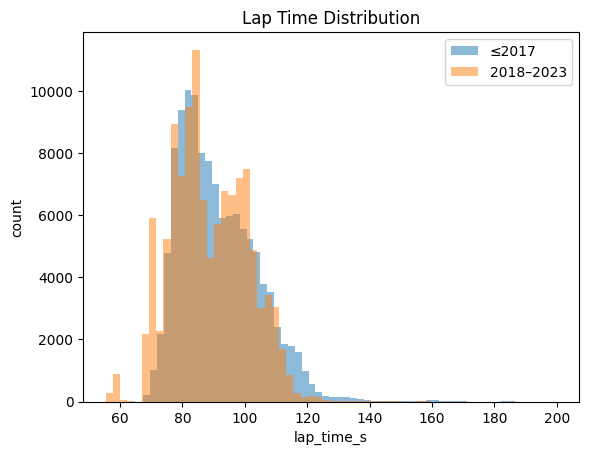

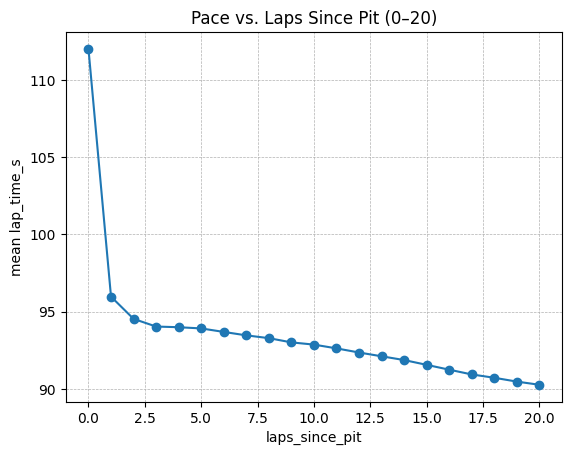

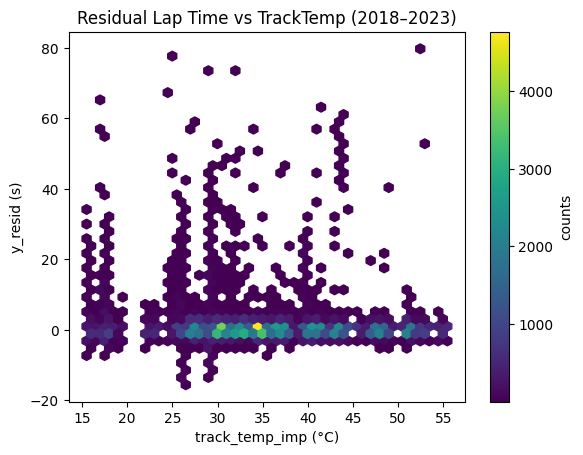

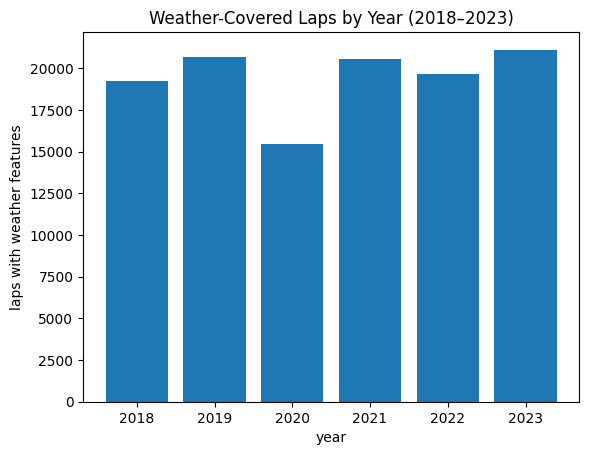

In [ ]:
# Step 8 — Quick exploratory plots (Matplotlib only, one figure per plot)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

assert 'train_df' in globals() and 'MODEL_A_DF' in globals() and 'MODEL_B_DF' in globals(), \
    "Please run the previous steps to create train_df / MODEL_A_DF / MODEL_B_DF."

# 1) Lap time distribution: modern (2018–2023) vs older seasons
plt.figure()
modern = train_df[train_df['year'].between(2018, 2023)]['lap_time_s'].dropna()
older  = train_df[~train_df['year'].between(2018, 2023)]['lap_time_s'].dropna()
modern_sample = modern.sample(min(len(modern), 120_000), random_state=42)
older_sample  = older.sample(min(len(older), 120_000), random_state=42)
plt.hist(older_sample, bins=60, alpha=0.5, label='≤2017')
plt.hist(modern_sample, bins=60, alpha=0.5, label='2018–2023')
plt.title('Lap Time Distribution')
plt.xlabel('lap_time_s')
plt.ylabel('count')
plt.legend()
plt.show()

# 2) Pace decay within stints: mean lap_time_s by laps_since_pit (cap at 20)
plt.figure()
df_pace = (train_df[train_df['laps_since_pit'].between(0, 20)]
           .groupby('laps_since_pit')['lap_time_s']
           .agg(['mean','count','std'])
           .reset_index())
plt.plot(df_pace['laps_since_pit'], df_pace['mean'], marker='o')
plt.title('Pace vs. Laps Since Pit (0–20)')
plt.xlabel('laps_since_pit')
plt.ylabel('mean lap_time_s')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# 3) Weather effect: residual vs track temperature (Model B only)
plt.figure()
mb = MODEL_B_DF[['y_resid','track_temp_imp']].dropna()
mb_sample = mb.sample(min(len(mb), 150_000), random_state=42)
plt.hexbin(mb_sample['track_temp_imp'], mb_sample['y_resid'], gridsize=40, mincnt=1)
plt.title('Residual Lap Time vs TrackTemp (2018–2023)')
plt.xlabel('track_temp_imp (°C)')
plt.ylabel('y_resid (s)')
cb = plt.colorbar()
cb.set_label('counts')
plt.show()

# 4) Weather coverage by year (Model B subset)
plt.figure()
year_counts = MODEL_B_DF['year'].value_counts().sort_index()
plt.bar(year_counts.index.astype(int), year_counts.values)
plt.title('Weather-Covered Laps by Year (2018–2023)')
plt.xlabel('year')
plt.ylabel('laps with weather features')
plt.show()


In [ ]:
# Step 9 — Pre-processing: build model-ready matrices for A & B (no training)

import numpy as np
import pandas as pd

# sanity: require the prepared tables & feature lists from earlier steps
for v in ["MODEL_A_DF","MODEL_B_DF","FEATURES_A","FEATURES_B","TARGET_A","TARGET_B","FOLDS_A","FOLDS_B"]:
    assert v in globals(), f"Missing {v}. Run the previous steps."

def to_float32(df, cols):
    X = pd.DataFrame({c: pd.to_numeric(df[c], errors="coerce") for c in cols}, index=df.index)
    # final safety: no infs
    X = X.replace([np.inf, -np.inf], np.nan)
    # rare fallback: if any remain NaN, fill with column median (should be none)
    med = X.median()
    X = X.fillna(med)
    return X.astype("float32").values

# ----- Model A -----
Xa = to_float32(MODEL_A_DF, FEATURES_A)
ya = pd.to_numeric(MODEL_A_DF[TARGET_A], errors="coerce").astype("float32").values
event_med_a = pd.to_numeric(MODEL_A_DF["event_median"], errors="coerce").astype("float32").values
groups_a = MODEL_A_DF["raceId"].values

print(f"Model A -> X: {Xa.shape}, y: {ya.shape}, features: {len(FEATURES_A)}")
print("  Any NaNs in X?", np.isnan(Xa).any(), "| Any NaNs in y?", np.isnan(ya).any())

# ----- Model B -----
Xb = to_float32(MODEL_B_DF, FEATURES_B)
yb = pd.to_numeric(MODEL_B_DF[TARGET_B], errors="coerce").astype("float32").values
event_med_b = pd.to_numeric(MODEL_B_DF["event_median"], errors="coerce").astype("float32").values
groups_b = MODEL_B_DF["raceId"].values

print(f"Model B -> X: {Xb.shape}, y: {yb.shape}, features: {len(FEATURES_B)}")
print("  Any NaNs in X?", np.isnan(Xb).any(), "| Any NaNs in y?", np.isnan(yb).any())

# Pack everything to use on the next step
DATA_A = {"X": Xa, "y": ya, "event_median": event_med_a, "groups": groups_a, "folds": FOLDS_A, "features": FEATURES_A}
DATA_B = {"X": Xb, "y": yb, "event_median": event_med_b, "groups": groups_b, "folds": FOLDS_B, "features": FEATURES_B}

print("\nReady for training. Use DATA_A / DATA_B with their folds.")


Model A -> X: (517523, 10), y: (517523,), features: 10
  Any NaNs in X? False | Any NaNs in y? False
Model B -> X: (116619, 14), y: (116619,), features: 14
  Any NaNs in X? False | Any NaNs in y? False

Ready for training. Use DATA_A / DATA_B with their folds.


In [ ]:
# SAFE MATRIX REBUILD — handles odd columns & ensures 1-D numeric arrays

import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold

assert 'MODEL_A_DF' in globals() and 'MODEL_B_DF' in globals(), "Recreate MODEL_A_DF / MODEL_B_DF first."
assert 'FEATURES_A' in globals() and 'FEATURES_B' in globals(), "Recreate FEATURES_A / FEATURES_B first."
assert 'TARGET_A' in globals() and 'TARGET_B' in globals(), "Recreate TARGET_A / TARGET_B first."

def clean_feature_list(df, feats):
    safe = []
    for f in feats:
        # keep only simple, present, non-list features
        if isinstance(f, (list, tuple, np.ndarray)):
            continue
        f = str(f)
        if f in df.columns:
            safe.append(f)
    # drop exact duplicates preserving order
    seen = set()
    uniq = []
    for f in safe:
        if f not in seen:
            uniq.append(f); seen.add(f)
    return uniq

FEATURES_A = clean_feature_list(MODEL_A_DF, FEATURES_A)
FEATURES_B = clean_feature_list(MODEL_B_DF, FEATURES_B)

def build_matrix(df, cols):
    # select strictly by column labels (1-D Series each)
    Xdf = df.loc[:, cols].copy()
    # coerce everything column-wise to numeric
    Xdf = Xdf.apply(lambda s: pd.to_numeric(s, errors='coerce'))
    # remove infs, fill remaining NaNs with per-column median
    Xdf.replace([np.inf, -np.inf], np.nan, inplace=True)
    Xdf.fillna(Xdf.median(numeric_only=True), inplace=True)
    return Xdf.to_numpy(dtype='float32')

# Rebuild folds to match current dataframes (fresh indices)
gkf = GroupKFold(n_splits=5)
FOLDS_A = list(gkf.split(np.arange(len(MODEL_A_DF)), MODEL_A_DF[TARGET_A].values, MODEL_A_DF['raceId'].values))
FOLDS_B = list(gkf.split(np.arange(len(MODEL_B_DF)), MODEL_B_DF[TARGET_B].values, MODEL_B_DF['raceId'].values))

# Matrices
Xa = build_matrix(MODEL_A_DF, FEATURES_A)
ya = MODEL_A_DF[TARGET_A].astype('float32').to_numpy()
evmed_a = MODEL_A_DF['event_median'].astype('float32').to_numpy()

Xb = build_matrix(MODEL_B_DF, FEATURES_B)
yb = MODEL_B_DF[TARGET_B].astype('float32').to_numpy()
evmed_b = MODEL_B_DF['event_median'].astype('float32').to_numpy()

DATA_A = {"X": Xa, "y": ya, "event_median": evmed_a, "folds": FOLDS_A, "features": FEATURES_A}
DATA_B = {"X": Xb, "y": yb, "event_median": evmed_b, "folds": FOLDS_B, "features": FEATURES_B}

print("A:", Xa.shape, "B:", Xb.shape, "| any NaNs in A:", np.isnan(Xa).any(), "in B:", np.isnan(Xb).any())
print("Features A:", FEATURES_A)
print("Features B:", FEATURES_B)


A: (506513, 14) B: (114205, 21) | any NaNs in A: False in B: False
Features A: ['lap', 'laps_since_pit', 'stint_id', 'prev_lap_time', 'prev2_lap_time', 'ma3_prev', 'ma5_prev', 'delta_prev_past', 'prev_lap_time_dm', 'ma3_prev_dm', 'ma5_prev_dm']
Features B: ['lap', 'laps_since_pit', 'stint_id', 'prev_lap_time', 'prev2_lap_time', 'ma3_prev', 'ma5_prev', 'delta_prev_past', 'prev_lap_time_dm', 'ma3_prev_dm', 'ma5_prev_dm', 'has_weather', 'track_temp_imp', 'air_temp_imp', 'humidity_imp', 'wind_speed_imp', 'wind_dir_imp', 'rainfall_imp']


In [ ]:
# FIX: drop duplicate columns in MODEL_A_DF, realign FEATURES_A, rebuild DATA_A

import numpy as np, pandas as pd
from sklearn.model_selection import GroupKFold

assert 'MODEL_A_DF' in globals() and 'FEATURES_A' in globals(), "Need MODEL_A_DF and FEATURES_A."

# 1) Show & drop duplicate columns (keep first occurrence)
dupe_mask = MODEL_A_DF.columns.duplicated(keep='first')
dupes = MODEL_A_DF.columns[dupe_mask].tolist()
print("Duplicate columns removed:", dupes if dupes else "None")
MODEL_A_DF = MODEL_A_DF.loc[:, ~dupe_mask].copy()

# 2) Ensure the feature list only contains columns that exist (and are unique)
FEATURES_A = [c for c in FEATURES_A if c in MODEL_A_DF.columns]
print("Features A (after alignment):", FEATURES_A)

# 3) Build X strictly from FEATURES_A (guarantees num_feature == len(FEATURES_A))
XdfA = MODEL_A_DF.loc[:, FEATURES_A].copy()
XdfA = XdfA.apply(lambda s: pd.to_numeric(s, errors='coerce'))
XdfA.replace([np.inf, -np.inf], np.nan, inplace=True)
XdfA.fillna(XdfA.median(numeric_only=True), inplace=True)
Xa = XdfA.to_numpy(dtype='float32')

ya     = pd.to_numeric(MODEL_A_DF['y_resid'], errors='coerce').astype('float32').to_numpy()
evmedA = pd.to_numeric(MODEL_A_DF['event_median'], errors='coerce').astype('float32').to_numpy()

# 4) Fresh GroupKFold splits to match the current rows
gkf = GroupKFold(n_splits=5)
idx = np.arange(len(MODEL_A_DF))
FOLDS_A = list(gkf.split(idx, ya, MODEL_A_DF['raceId'].values))

# 5) Pack DATA_A (now perfectly aligned)
DATA_A = {"X": Xa, "y": ya, "event_median": evmedA, "folds": FOLDS_A, "features": FEATURES_A}

print("A matrix:", Xa.shape, "| features:", len(FEATURES_A), "| any NaNs in X:", np.isnan(Xa).any())


Duplicate columns removed: ['lap', 'laps_since_pit', 'stint_id']
Features A (after alignment): ['lap', 'laps_since_pit', 'stint_id', 'prev_lap_time', 'prev2_lap_time', 'ma3_prev', 'ma5_prev', 'delta_prev_past', 'prev_lap_time_dm', 'ma3_prev_dm', 'ma5_prev_dm']
A matrix: (506513, 11) | features: 11 | any NaNs in X: False


In [ ]:
# Retrain Model A — pass feature_name so importances align perfectly

import numpy as np, lightgbm as lgb
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

Xa, ya = DATA_A["X"], DATA_A["y"]
folds  = DATA_A["folds"]
evmed  = DATA_A["event_median"]
feat   = DATA_A["features"]

params = dict(
    objective="regression",
    metric="l2",
    learning_rate=0.05,
    num_leaves=64,
    max_depth=-1,
    min_data_in_leaf=200,
    feature_fraction=0.9,
    bagging_fraction=0.9,
    bagging_freq=1,
    lambda_l1=0.0, lambda_l2=2.0,
    seed=42, verbose=-1
)

oof = np.zeros(len(ya), dtype=np.float32)
models = []
for k, (tr, va) in enumerate(folds, 1):
    dtr = lgb.Dataset(Xa[tr], label=ya[tr], feature_name=feat)
    dva = lgb.Dataset(Xa[va], label=ya[va], feature_name=feat)
    model = lgb.train(
        params, dtr, num_boost_round=5000,
        valid_sets=[dtr, dva], valid_names=["train","valid"],
        callbacks=[lgb.early_stopping(stopping_rounds=200), lgb.log_evaluation(period=200)],
    )
    oof[va] = model.predict(Xa[va], num_iteration=model.best_iteration)
    models.append(model)

# Metrics on true lap times
y_true_lap = ya + evmed
y_pred_lap = oof + evmed
mae  = mean_absolute_error(y_true_lap, y_pred_lap)
rmse = sqrt(((y_true_lap - y_pred_lap)**2).mean())
r2   = r2_score(y_true_lap, y_pred_lap)
print(f"\nModel A OOF → MAE: {mae:.3f}s   RMSE: {rmse:.3f}s   R²: {r2:.3f}")

# Feature importances (aligned)
gain = np.zeros(len(feat))
for m in models:
    g = np.array(m.feature_importance(importance_type="gain"))
    if g.shape[0] != len(feat):
        # safety (shouldn't trigger now that feature_name is set)
        g = g[:len(feat)]
    gain += g / max(g.sum(), 1e-9)
order = gain.argsort()[::-1]
print("\nTop features (avg gain):")
for i in order[:10]:
    print(f"  {feat[i]}")

MODELA_MODELS = models


Training until validation scores don't improve for 200 rounds
[200]	train's l2: 3.70211	valid's l2: 5.1159
Early stopping, best iteration is:
[82]	train's l2: 4.07131	valid's l2: 5.07033
Training until validation scores don't improve for 200 rounds
[200]	train's l2: 3.75167	valid's l2: 4.26974
Early stopping, best iteration is:
[86]	train's l2: 4.17425	valid's l2: 4.16869
Training until validation scores don't improve for 200 rounds
[200]	train's l2: 3.4821	valid's l2: 5.92053
Early stopping, best iteration is:
[68]	train's l2: 3.94632	valid's l2: 5.75495
Training until validation scores don't improve for 200 rounds
[200]	train's l2: 3.58359	valid's l2: 5.2869
Early stopping, best iteration is:
[81]	train's l2: 4.0295	valid's l2: 5.12742
Training until validation scores don't improve for 200 rounds
[200]	train's l2: 3.76538	valid's l2: 4.05773
Early stopping, best iteration is:
[96]	train's l2: 4.1298	valid's l2: 4.01393

Model A OOF → MAE: 0.748s   RMSE: 2.197s   R²: 0.969

Top featur

In [ ]:
# Honest baseline: predict absolute lap_time_s (no event_median, no *_dm features)

import numpy as np, pandas as pd, lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

# 1) Build a clean feature set (past-only, no de-meaning)
FEATS_A_ABS = [
    'lap','laps_since_pit','stint_id',
    'prev_lap_time','prev2_lap_time','ma3_prev','ma5_prev','delta_prev_past'
]
TARGET_ABS = 'lap_time_s'

# Filter rows that have history for prev_* features
A_abs = MODEL_A_DF[['raceId', TARGET_ABS] + FEATS_A_ABS].dropna(subset=['prev_lap_time']).reset_index(drop=True)

# Matrices
Xabs = A_abs[FEATS_A_ABS].apply(lambda s: pd.to_numeric(s, errors='coerce')).replace([np.inf,-np.inf], np.nan)
Xabs = Xabs.fillna(Xabs.median(numeric_only=True)).to_numpy(dtype='float32')
yabs = pd.to_numeric(A_abs[TARGET_ABS], errors='coerce').to_numpy(dtype='float32')

# GroupKFold by raceId (leak-free)
gkf = GroupKFold(n_splits=5)
folds_abs = list(gkf.split(np.arange(len(A_abs)), yabs, A_abs['raceId'].to_numpy()))

# 2) Train LightGBM (callbacks for early stopping)
params = dict(
    objective="regression",
    metric="l2",
    learning_rate=0.05,
    num_leaves=64,
    max_depth=-1,
    min_data_in_leaf=200,
    feature_fraction=0.9,
    bagging_fraction=0.9,
    bagging_freq=1,
    lambda_l1=0.0, lambda_l2=2.0,
    seed=42, verbose=-1
)

oof = np.zeros_like(yabs, dtype='float32')
models_abs = []
for k, (tr, va) in enumerate(folds_abs, 1):
    dtr = lgb.Dataset(Xabs[tr], label=yabs[tr], feature_name=FEATS_A_ABS)
    dva = lgb.Dataset(Xabs[va], label=yabs[va], feature_name=FEATS_A_ABS)
    model = lgb.train(
        params, dtr, num_boost_round=5000,
        valid_sets=[dtr, dva], valid_names=["train","valid"],
        callbacks=[lgb.early_stopping(stopping_rounds=200), lgb.log_evaluation(period=200)],
    )
    oof[va] = model.predict(Xabs[va], num_iteration=model.best_iteration)
    models_abs.append(model)

mae  = mean_absolute_error(yabs, oof)
rmse = sqrt(((yabs - oof)**2).mean())
r2   = r2_score(yabs, oof)
print(f"\nModel A (no residualization) → MAE: {mae:.3f}s   RMSE: {rmse:.3f}s   R²: {r2:.3f}")

print("\nTop features (avg gain):")
gain = np.zeros(len(FEATS_A_ABS))
for m in models_abs:
    g = np.array(m.feature_importance(importance_type="gain"))
    s = g.sum()
    if s > 0: gain += g / s
order = gain.argsort()[::-1]
for i in order[:10]:
    print(f"  {FEATS_A_ABS[i]}")


Training until validation scores don't improve for 200 rounds
[200]	train's l2: 4.15258	valid's l2: 6.93992
[400]	train's l2: 3.89246	valid's l2: 6.9438
Early stopping, best iteration is:
[270]	train's l2: 4.04466	valid's l2: 6.92298
Training until validation scores don't improve for 200 rounds
[200]	train's l2: 4.39319	valid's l2: 4.77363
Early stopping, best iteration is:
[79]	train's l2: 4.85912	valid's l2: 4.64412
Training until validation scores don't improve for 200 rounds
[200]	train's l2: 4.06193	valid's l2: 7.74847
Early stopping, best iteration is:
[127]	train's l2: 4.23761	valid's l2: 7.68954
Training until validation scores don't improve for 200 rounds
[200]	train's l2: 4.22241	valid's l2: 4.81869
Early stopping, best iteration is:
[99]	train's l2: 4.54945	valid's l2: 4.74802
Training until validation scores don't improve for 200 rounds
[200]	train's l2: 4.42091	valid's l2: 4.55228
Early stopping, best iteration is:
[95]	train's l2: 4.77564	valid's l2: 4.48062

Model A (no 

In [ ]:
# B-FIX — dedupe MODEL_B_DF columns, align FEATURES_B, rebuild DATA_B

import numpy as np, pandas as pd
from sklearn.model_selection import GroupKFold

assert 'MODEL_B_DF' in globals() and 'FEATURES_B' in globals() and 'TARGET_B' in globals()

# 1) Drop duplicate-named columns (keep first)
dupe_mask = MODEL_B_DF.columns.duplicated(keep='first')
dupes = MODEL_B_DF.columns[dupe_mask].tolist()
print("Duplicate columns removed (B):", dupes if dupes else "None")
MODEL_B_DF = MODEL_B_DF.loc[:, ~dupe_mask].copy()

# 2) Keep only features that currently exist (and in this order)
FEATURES_B = [c for c in FEATURES_B if c in MODEL_B_DF.columns]
print("Features_B (aligned):", FEATURES_B)

# 3) Build X strictly from FEATURES_B (ensures #cols == len(FEATURES_B))
XdfB = MODEL_B_DF.loc[:, FEATURES_B].copy()
XdfB = XdfB.apply(lambda s: pd.to_numeric(s, errors='coerce'))
XdfB.replace([np.inf, -np.inf], np.nan, inplace=True)
XdfB.fillna(XdfB.median(numeric_only=True), inplace=True)
Xb = XdfB.to_numpy(dtype='float32')

yb      = pd.to_numeric(MODEL_B_DF[TARGET_B], errors='coerce').astype('float32').to_numpy()
evmedB  = pd.to_numeric(MODEL_B_DF['event_median'], errors='coerce').astype('float32').to_numpy()

# 4) Fresh GroupKFold (rows may have changed)
gkf = GroupKFold(n_splits=5)
idx = np.arange(len(MODEL_B_DF))
FOLDS_B = list(gkf.split(idx, yb, MODEL_B_DF['raceId'].values))

DATA_B = {"X": Xb, "y": yb, "event_median": evmedB, "folds": FOLDS_B, "features": FEATURES_B}

print("B matrix:", Xb.shape, "| features:", len(FEATURES_B), "| any NaNs:", np.isnan(Xb).any())


Duplicate columns removed (B): ['lap', 'laps_since_pit', 'stint_id']
Features_B (aligned): ['lap', 'laps_since_pit', 'stint_id', 'prev_lap_time', 'prev2_lap_time', 'ma3_prev', 'ma5_prev', 'delta_prev_past', 'prev_lap_time_dm', 'ma3_prev_dm', 'ma5_prev_dm', 'has_weather', 'track_temp_imp', 'air_temp_imp', 'humidity_imp', 'wind_speed_imp', 'wind_dir_imp', 'rainfall_imp']
B matrix: (114205, 18) | features: 18 | any NaNs: False


In [ ]:
# Train Model B (2018–2023 + weather) — LightGBM 4.x + callbacks
import numpy as np, lightgbm as lgb
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

Xb, yb   = DATA_B["X"], DATA_B["y"]            # yb is residual (y_resid)
folds    = DATA_B["folds"]
evmed    = DATA_B["event_median"]
feat     = DATA_B["features"]

params = dict(
    objective="regression",
    metric="l2",
    learning_rate=0.05,
    num_leaves=64,
    max_depth=-1,
    min_data_in_leaf=200,
    feature_fraction=0.9,
    bagging_fraction=0.9,
    bagging_freq=1,
    lambda_l1=0.0, lambda_l2=2.0,
    seed=42, verbose=-1
)

oof_b = np.zeros(len(yb), dtype=np.float32)
models_b = []
for k, (tr, va) in enumerate(folds, 1):
    dtr = lgb.Dataset(Xb[tr], label=yb[tr], feature_name=feat)
    dva = lgb.Dataset(Xb[va], label=yb[va], feature_name=feat)
    model = lgb.train(
        params, dtr, num_boost_round=5000,
        valid_sets=[dtr, dva], valid_names=["train","valid"],
        callbacks=[lgb.early_stopping(stopping_rounds=200), lgb.log_evaluation(period=200)],
    )
    oof_b[va] = model.predict(Xb[va], num_iteration=model.best_iteration)
    models_b.append(model)

# Convert residual predictions back to absolute lap time for reporting
y_true_lap = yb + evmed
y_pred_lap = oof_b + evmed
mae  = mean_absolute_error(y_true_lap, y_pred_lap)
rmse = sqrt(((y_true_lap - y_pred_lap)**2).mean())
r2   = r2_score(y_true_lap, y_pred_lap)
print(f"\nModel B (2018–2023 + weather) → MAE: {mae:.3f}s   RMSE: {rmse:.3f}s   R²: {r2:.3f}")

# Feature importances (aligned)
gain = np.zeros(len(feat))
for m in models_b:
    g = np.array(m.feature_importance(importance_type="gain"))
    s = g.sum()
    if s > 0: gain += g / s
order = gain.argsort()[::-1]
print("\nTop features (avg gain):")
for i in order[:12]:
    print(f"  {feat[i]}")

MODEL_B_MODELS = models_b


Training until validation scores don't improve for 200 rounds
[200]	train's l2: 2.03008	valid's l2: 2.48692
Early stopping, best iteration is:
[111]	train's l2: 2.24352	valid's l2: 2.42939
Training until validation scores don't improve for 200 rounds
[200]	train's l2: 2.0749	valid's l2: 1.18005
Early stopping, best iteration is:
[53]	train's l2: 2.55062	valid's l2: 1.14175
Training until validation scores don't improve for 200 rounds
[200]	train's l2: 1.69136	valid's l2: 3.27048
[400]	train's l2: 1.44644	valid's l2: 3.26811
Early stopping, best iteration is:
[307]	train's l2: 1.54367	valid's l2: 3.24997
Training until validation scores don't improve for 200 rounds
[200]	train's l2: 1.70453	valid's l2: 3.82901
[400]	train's l2: 1.50491	valid's l2: 3.71148
[600]	train's l2: 1.36315	valid's l2: 3.67799
Early stopping, best iteration is:
[583]	train's l2: 1.37325	valid's l2: 3.6711
Training until validation scores don't improve for 200 rounds
[200]	train's l2: 1.86794	valid's l2: 2.40399
E

In [ ]:
# Re-train Model B on ABSOLUTE lap_time_s (no residualization, no *_dm features)

import numpy as np, pandas as pd, lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

# 1) Feature list: past-only pace + weather (no *_dm)
WEATHER_IMP = [c for c in MODEL_B_DF.columns if c.endswith('_imp')]
FEATS_B_ABS = [
    'lap','laps_since_pit','stint_id',
    'prev_lap_time','prev2_lap_time','ma3_prev','ma5_prev','delta_prev_past',
    'has_weather'
] + WEATHER_IMP

TARGET_ABS = 'lap_time_s'

# 2) Build dataset (drop rows without prev history)
B_abs = MODEL_B_DF[['raceId', TARGET_ABS] + FEATS_B_ABS].dropna(subset=['prev_lap_time']).reset_index(drop=True)

Xb = B_abs[FEATS_B_ABS].apply(lambda s: pd.to_numeric(s, errors='coerce')).replace([np.inf,-np.inf], np.nan)
Xb = Xb.fillna(Xb.median(numeric_only=True)).to_numpy(dtype='float32')
yb = pd.to_numeric(B_abs[TARGET_ABS], errors='coerce').to_numpy(dtype='float32')

# 3) GroupKFold by raceId (leak-free)
gkf = GroupKFold(n_splits=5)
folds = list(gkf.split(np.arange(len(B_abs)), yb, B_abs['raceId'].to_numpy()))

# 4) Train LightGBM with early stopping (callbacks API for v4.x)
params = dict(
    objective="regression",
    metric="l2",
    learning_rate=0.05,
    num_leaves=64,
    max_depth=-1,
    min_data_in_leaf=200,
    feature_fraction=0.9,
    bagging_fraction=0.9,
    bagging_freq=1,
    lambda_l1=0.0, lambda_l2=2.0,
    seed=42, verbose=-1
)

oof = np.zeros_like(yb, dtype='float32')
models_b_abs = []
for k, (tr, va) in enumerate(folds, 1):
    dtr = lgb.Dataset(Xb[tr], label=yb[tr], feature_name=FEATS_B_ABS)
    dva = lgb.Dataset(Xb[va], label=yb[va], feature_name=FEATS_B_ABS)
    model = lgb.train(
        params, dtr, num_boost_round=5000,
        valid_sets=[dtr, dva], valid_names=["train","valid"],
        callbacks=[lgb.early_stopping(stopping_rounds=200), lgb.log_evaluation(period=200)],
    )
    oof[va] = model.predict(Xb[va], num_iteration=model.best_iteration)
    models_b_abs.append(model)

mae  = mean_absolute_error(yb, oof)
rmse = sqrt(((yb - oof)**2).mean())
r2   = r2_score(yb, oof)
print(f"\nModel B ABS (2018–2023 + weather) → MAE: {mae:.3f}s   RMSE: {rmse:.3f}s   R²: {r2:.3f}")

print("\nTop features (avg gain):")
gain = np.zeros(len(FEATS_B_ABS))
for m in models_b_abs:
    g = np.array(m.feature_importance(importance_type="gain"))
    s = g.sum()
    if s > 0: gain += g / s
for i in gain.argsort()[::-1][:12]:
    print(f"  {FEATS_B_ABS[i]}")


Training until validation scores don't improve for 200 rounds
[200]	train's l2: 1.97408	valid's l2: 2.141
Early stopping, best iteration is:
[78]	train's l2: 2.3274	valid's l2: 2.09973
Training until validation scores don't improve for 200 rounds
[200]	train's l2: 2.09587	valid's l2: 1.38623
Early stopping, best iteration is:
[106]	train's l2: 2.33193	valid's l2: 1.34265
Training until validation scores don't improve for 200 rounds
[200]	train's l2: 1.68825	valid's l2: 8.29543
Early stopping, best iteration is:
[177]	train's l2: 1.73051	valid's l2: 8.27567
Training until validation scores don't improve for 200 rounds
[200]	train's l2: 1.75541	valid's l2: 3.53507
Early stopping, best iteration is:
[127]	train's l2: 1.87661	valid's l2: 3.51715
Training until validation scores don't improve for 200 rounds
[200]	train's l2: 1.89963	valid's l2: 5.01527
Early stopping, best iteration is:
[121]	train's l2: 2.08525	valid's l2: 4.83032

Model B ABS (2018–2023 + weather) → MAE: 0.748s   RMSE: 1.

In [ ]:
# Per-event metrics for Model B ABS (2018–2023 + weather)

import pandas as pd
import numpy as np

# Uses B_abs (dataframe with 'raceId' and y), and 'oof' from the last Model B ABS training cell
assert 'B_abs' in globals() and 'oof' in globals(), "Please run the Model B ABS training cell first."

# Join race names for readability (requires 'races' loaded earlier)
assert 'races' in globals(), "Please reload 'races' if the runtime was reset."

res_b = B_abs[['raceId']].copy()
res_b['y_true'] = B_abs['lap_time_s'].values.astype('float32')
res_b['y_pred'] = oof.astype('float32')
res_b['ae'] = (res_b['y_true'] - res_b['y_pred']).abs()
res_b['se'] = (res_b['y_true'] - res_b['y_pred'])**2

evt = races[['raceId','year','round','name']].drop_duplicates()
evt_b = res_b.merge(evt, on='raceId', how='left')

per_event = (evt_b.groupby(['year','round','name'], as_index=False)
             .agg(MAE=('ae','mean'),
                  RMSE=('se', lambda x: np.sqrt(np.mean(x))),
                  N=('ae','size'))
             .sort_values(['year','round']))

print("Per-event metrics (Model B ABS):")
print(per_event.head(20).to_string(index=False))

# Best/worst 8 events by MAE
print("\nBest events by MAE:")
print(per_event.nsmallest(8, 'MAE').to_string(index=False))
print("\nHardest events by MAE:")
print(per_event.nlargest(8, 'MAE').to_string(index=False))


Per-event metrics (Model B ABS):
 year  round                     name      MAE     RMSE    N
 2018      1    Australian Grand Prix 0.493947 0.971785  782
 2018      2       Bahrain Grand Prix 0.403721 0.632503  842
 2018      3       Chinese Grand Prix 0.379471 0.579241  936
 2018      4    Azerbaijan Grand Prix 1.411485 4.294827  602
 2018      5       Spanish Grand Prix 0.669038 2.863441  829
 2018      6        Monaco Grand Prix 0.463158 0.693366 1363
 2018      7      Canadian Grand Prix 0.407876 0.577149 1036
 2018      8        French Grand Prix 0.443434 0.695189  742
 2018      9      Austrian Grand Prix 0.419053 0.581894 1106
 2018     10       British Grand Prix 0.414976 0.614412  669
 2018     11        German Grand Prix 0.496475 0.739392  997
 2018     12     Hungarian Grand Prix 0.546804 0.777155 1077
 2018     13       Belgian Grand Prix 0.627249 2.206865  576
 2018     14       Italian Grand Prix 0.541998 1.615551  787
 2018     15     Singapore Grand Prix 0.771393 1.149

In [ ]:
# Print accuracies for Model A (ABS) and Model B (ABS+Weather)

import numpy as np
from math import sqrt
from sklearn.metrics import mean_absolute_error, r2_score

def summarize(name, y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(((y_true - y_pred)**2).mean())
    r2   = r2_score(y_true, y_pred)
    print(f"{name} → MAE: {mae:.3f}s   RMSE: {rmse:.3f}s   R²: {r2:.3f}")
    return mae, rmse, r2

results = {}

# ---- Model A ABS (no weather) ----
if all(v in globals() for v in ["models_abs","folds_abs","Xabs","yabs"]):
    oof_a = np.zeros_like(yabs, dtype="float32")
    for m, (tr, va) in zip(models_abs, folds_abs):
        oof_a[va] = m.predict(Xabs[va], num_iteration=m.best_iteration)
    results["A"] = summarize("Model A (no weather)", yabs, oof_a)
else:
    print("Model A objects not found (models_abs / folds_abs / Xabs / yabs). "
          "Re-run the Model A ABS training cell if you want its metrics here.")

# ---- Model B ABS (with weather) ----
# In your last training cell these were named: models_b_abs, folds, Xb, yb
if all(v in globals() for v in ["models_b_abs","folds","Xb","yb"]):
    oof_b = np.zeros_like(yb, dtype="float32")
    for m, (tr, va) in zip(models_b_abs, folds):
        oof_b[va] = m.predict(Xb[va], num_iteration=m.best_iteration)
    results["B"] = summarize("Model B (2018–2023 + weather)", yb, oof_b)
else:
    print("Model B objects not found (models_b_abs / folds / Xb / yb). "
          "Re-run the Model B ABS training cell if you want its metrics here.")

# ---- Improvement summary (if both are available) ----
if "A" in results and "B" in results:
    (mae_a, rmse_a, r2_a) = results["A"]
    (mae_b, rmse_b, r2_b) = results["B"]
    print("\nWeather gain (B vs A):")
    print(f"  MAE:  {mae_a - mae_b:+.3f}s  ({(1 - mae_b/mae_a)*100:+.1f}%)")
    print(f"  RMSE: {rmse_a - rmse_b:+.3f}s  ({(1 - rmse_b/rmse_a)*100:+.1f}%)")
    print(f"  R²:   {r2_b - r2_a:+.3f}")


Model A (no weather) → MAE: 0.803s   RMSE: 2.387s   R²: 0.964
Model B (2018–2023 + weather) → MAE: 0.748s   RMSE: 1.999s   R²: 0.973

Weather gain (B vs A):
  MAE:  +0.056s  (+6.9%)
  RMSE: +0.388s  (+16.2%)
  R²:   +0.009


In [ ]:
# Tolerance "accuracy" for regression: % of laps within ±τ seconds

import numpy as np

# expects these from your earlier cells:
# A: yabs (true), oof_a (pred)
# B: yb   (true), oof_b (pred)

def tol_acc(y_true, y_pred, tau):
    return float(np.mean(np.abs(y_true - y_pred) <= tau) * 100.0)

# If oof arrays aren't in memory, reconstruct quickly
if 'oof_a' not in globals() and all(v in globals() for v in ["models_abs","folds_abs","Xabs"]):
    oof_a = np.zeros_like(yabs, dtype="float32")
    for m, (tr, va) in zip(models_abs, folds_abs):
        oof_a[va] = m.predict(Xabs[va], num_iteration=m.best_iteration)

if 'oof_b' not in globals() and all(v in globals() for v in ["models_b_abs","folds","Xb"]):
    oof_b = np.zeros_like(yb, dtype="float32")
    for m, (tr, va) in zip(models_b_abs, folds):
        oof_b[va] = m.predict(Xb[va], num_iteration=m.best_iteration)

for tau in (0.5, 1.0):
    a_acc = tol_acc(yabs, oof_a, tau)
    b_acc = tol_acc(yb,   oof_b, tau)
    print(f"Within ±{tau:.1f}s — A: {a_acc:5.1f}%   B: {b_acc:5.1f}%   (Δ={b_acc-a_acc:+.1f} pp)")


Within ±0.5s — A:  63.1%   B:  64.3%   (Δ=+1.2 pp)
Within ±1.0s — A:  83.8%   B:  84.4%   (Δ=+0.6 pp)


In [ ]:
# Step — Per-event comparison: Model A (no weather) vs Model B (with weather), 2018–2023 only

import numpy as np, pandas as pd

# 1) Rebuild OOFs if they aren't in memory
if 'oof_a' not in globals():
    assert all(v in globals() for v in ["models_abs","folds_abs","Xabs","yabs"]), "Re-run Model A ABS training."
    oof_a = np.zeros_like(yabs, dtype="float32")
    for m, (tr, va) in zip(models_abs, folds_abs):
        oof_a[va] = m.predict(Xabs[va], num_iteration=m.best_iteration)

if 'oof_b' not in globals():
    assert all(v in globals() for v in ["models_b_abs","folds","Xb","yb"]), "Re-run Model B ABS training."
    oof_b = np.zeros_like(yb, dtype="float32")
    for m, (tr, va) in zip(models_b_abs, folds):
        oof_b[va] = m.predict(Xb[va], num_iteration=m.best_iteration)

# 2) Build A/B per-lap DataFrames
dfA = A_abs[['raceId']].copy()
dfA['y_true'] = yabs
dfA['y_pred_A'] = oof_a

dfB = B_abs[['raceId']].copy()
dfB['y_true'] = yb
dfB['y_pred_B'] = oof_b

# 3) Join race metadata and filter to 2018–2023 (B’s coverage)
evt = races[['raceId','year','round','name']].drop_duplicates()
dfA = dfA.merge(evt, on='raceId', how='left')
dfB = dfB.merge(evt, on='raceId', how='left')

dfB_only = dfB[dfB['year'].between(2018, 2023)].copy()
dfA_2018 = dfA[dfA['year'].between(2018, 2023)].copy()

# 4) Per-event MAE for A and B, then compare
perA = (dfA_2018.groupby(['year','round','name'], as_index=False)
        .agg(MAE_A=('y_true', lambda z: np.mean(np.abs(z - dfA_2018.loc[z.index, 'y_pred_A']))),
             N_A=('y_true','size')))

perB = (dfB_only.groupby(['year','round','name'], as_index=False)
        .agg(MAE_B=('y_true', lambda z: np.mean(np.abs(z - dfB_only.loc[z.index, 'y_pred_B']))),
             N_B=('y_true','size')))

comp = (perB.merge(perA, on=['year','round','name'], how='inner')
            .assign(Delta_MAE=lambda d: d['MAE_A'] - d['MAE_B'])
            .sort_values(['year','round']))

print("Per-event MAE (A vs B) — first 15 events:")
print(comp.head(15).to_string(index=False, formatters={'MAE_A': '{:.3f}'.format,
                                                       'MAE_B': '{:.3f}'.format,
                                                       'Delta_MAE': '{:+.3f}'.format}))

print("\nTop 8 events where weather helped most (ΔMAE positive = B better):")
print(comp.nlargest(8, 'Delta_MAE')[['year','round','name','MAE_A','MAE_B','Delta_MAE']].to_string(index=False,
      formatters={'MAE_A': '{:.3f}'.format,'MAE_B': '{:.3f}'.format,'Delta_MAE': '{:+.3f}'.format}))

print("\nHardest 8 events (highest MAE_B):")
print(comp.nlargest(8, 'MAE_B')[['year','round','name','MAE_B','MAE_A','Delta_MAE']].to_string(index=False,
      formatters={'MAE_A': '{:.3f}'.format,'MAE_B': '{:.3f}'.format,'Delta_MAE': '{:+.3f}'.format}))


Per-event MAE (A vs B) — first 15 events:
 year  round                  name MAE_B  N_B MAE_A  N_A Delta_MAE
 2018      1 Australian Grand Prix 0.494  782 0.479  782    -0.015
 2018      2    Bahrain Grand Prix 0.404  842 0.389  842    -0.015
 2018      3    Chinese Grand Prix 0.379  936 0.384  936    +0.004
 2018      4 Azerbaijan Grand Prix 1.411  602 1.234  602    -0.178
 2018      5    Spanish Grand Prix 0.669  829 0.747  829    +0.078
 2018      6     Monaco Grand Prix 0.463 1363 0.459 1363    -0.004
 2018      7   Canadian Grand Prix 0.408 1036 0.432 1036    +0.024
 2018      8     French Grand Prix 0.443  742 0.476  742    +0.032
 2018      9   Austrian Grand Prix 0.419 1106 0.452 1106    +0.033
 2018     10    British Grand Prix 0.415  669 0.438  669    +0.023
 2018     11     German Grand Prix 0.496  997 0.495  997    -0.001
 2018     12  Hungarian Grand Prix 0.547 1077 0.513 1077    -0.033
 2018     13    Belgian Grand Prix 0.627  576 0.542  576    -0.085
 2018     14    Ital

In [ ]:
# Step — Save models + features + metadata, and add an inference helper

import os, json, time, numpy as np, pandas as pd, lightgbm as lgb
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

# ==== 0) Where to save ====
STAMP = time.strftime("%Y%m%d-%H%M%S")
BASE_DIR = f"/content/drive/MyDrive/f1_models/{STAMP}"
A_DIR = os.path.join(BASE_DIR, "model_A_abs_no_weather")
B_DIR = os.path.join(BASE_DIR, "model_B_abs_with_weather")
os.makedirs(A_DIR, exist_ok=True)
os.makedirs(B_DIR, exist_ok=True)

# ==== 1) Rebuild OOFs if needed (for metadata) ====
# Model A ABS (no weather)
if all(v in globals() for v in ["models_abs","folds_abs","Xabs","yabs"]):
    oof_a = np.zeros_like(yabs, dtype="float32")
    for m, (tr, va) in zip(models_abs, folds_abs):
        oof_a[va] = m.predict(Xabs[va], num_iteration=m.best_iteration)
    mae_a  = mean_absolute_error(yabs, oof_a)
    rmse_a = sqrt(((yabs - oof_a)**2).mean())
    r2_a   = r2_score(yabs, oof_a)
else:
    mae_a = rmse_a = r2_a = None

# Model B ABS (with weather)
# From the last training cell these were named: models_b_abs, folds, Xb, yb
if all(v in globals() for v in ["models_b_abs","folds","Xb","yb"]):
    oof_b = np.zeros_like(yb, dtype="float32")
    for m, (tr, va) in zip(models_b_abs, folds):
        oof_b[va] = m.predict(Xb[va], num_iteration=m.best_iteration)
    mae_b  = mean_absolute_error(yb, oof_b)
    rmse_b = sqrt(((yb - oof_b)**2).mean())
    r2_b   = r2_score(yb, oof_b)
else:
    mae_b = rmse_b = r2_b = None

# ==== 2) Save boosters ====
# A
assert 'models_abs' in globals(), "models_abs not found — re-run Model A ABS training."
for i, m in enumerate(models_abs, 1):
    m.save_model(os.path.join(A_DIR, f"lgb_A_fold{i}.txt"))

# B
assert 'models_b_abs' in globals(), "models_b_abs not found — re-run Model B ABS training."
for i, m in enumerate(models_b_abs, 1):
    m.save_model(os.path.join(B_DIR, f"lgb_B_fold{i}.txt"))

# ==== 3) Save feature lists & imputers used at inference ====
# A features
assert 'FEATS_A_ABS' in globals(), "FEATS_A_ABS missing — re-run the A ABS training cell."
with open(os.path.join(A_DIR, "features.json"), "w") as f:
    json.dump(FEATS_A_ABS, f, indent=2)

# B features + imputer medians (so you can predict even with a few missing cols)
assert 'FEATS_B_ABS' in globals(), "FEATS_B_ABS missing — re-run the B ABS training cell."
with open(os.path.join(B_DIR, "features.json"), "w") as f:
    json.dump(FEATS_B_ABS, f, indent=2)

# Build simple median imputers from the training frames we used
assert 'A_abs' in globals() and 'B_abs' in globals(), "A_abs / B_abs missing — they’re built in the ABS training cells."
imputer_A = A_abs[FEATS_A_ABS].apply(pd.to_numeric, errors='coerce').median(numeric_only=True).to_dict()
imputer_B = B_abs[FEATS_B_ABS].apply(pd.to_numeric, errors='coerce').median(numeric_only=True).to_dict()
with open(os.path.join(A_DIR, "imputer_median.json"), "w") as f:
    json.dump(imputer_A, f, indent=2)
with open(os.path.join(B_DIR, "imputer_median.json"), "w") as f:
    json.dump(imputer_B, f, indent=2)

# ==== 4) Save metadata (versions, metrics) ====
META = {
    "timestamp": STAMP,
    "packages": {
        "python":  f"{pd.__version__} (pandas version shown; Python available via sys.version if needed)",
        "pandas":  pd.__version__,
        "numpy":   np.__version__,
        "lightgbm": lgb.__version__
    },
    "model_A_abs": {"MAE": mae_a, "RMSE": rmse_a, "R2": r2_a, "n_features": len(FEATS_A_ABS)},
    "model_B_abs": {"MAE": mae_b, "RMSE": rmse_b, "R2": r2_b, "n_features": len(FEATS_B_ABS)}
}
with open(os.path.join(BASE_DIR, "metadata.json"), "w") as f:
    json.dump(META, f, indent=2)

print("Saved:")
print(" - Model A boosters ->", A_DIR)
print(" - Model B boosters ->", B_DIR)
print(" - metadata.json     ->", BASE_DIR)

# ==== 5) Inference helper (average ensemble of folds) ====
def _coerce_features(df, feature_list, imputer):
    X = df.copy()
    for c in feature_list:
        if c not in X.columns:
            # create missing with imputer median (or 0.0 if absent)
            X[c] = imputer.get(c, 0.0)
    X = X[feature_list].apply(lambda s: pd.to_numeric(s, errors='coerce'))
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(pd.Series(imputer))
    return X.to_numpy(dtype='float32')

def load_boosters(folder, pattern_prefix):
    files = sorted([p for p in os.listdir(folder) if p.startswith(pattern_prefix) and p.endswith(".txt")])
    boosters = [lgb.Booster(model_file=os.path.join(folder, p)) for p in files]
    return boosters

def predict_lap_time_A(df_features):
    """df_features: DataFrame with columns matching FEATS_A_ABS (missing columns will be imputed)."""
    boosters = load_boosters(A_DIR, "lgb_A_fold")
    with open(os.path.join(A_DIR, "features.json")) as f: feats = json.load(f)
    with open(os.path.join(A_DIR, "imputer_median.json")) as f: imp = json.load(f)
    X = _coerce_features(df_features, feats, imp)
    preds = np.column_stack([b.predict(X, num_iteration=b.best_iteration) for b in boosters]).mean(axis=1)
    return preds  # absolute lap_time_s

def predict_lap_time_B(df_features):
    """df_features: DataFrame with columns matching FEATS_B_ABS (missing columns will be imputed)."""
    boosters = load_boosters(B_DIR, "lgb_B_fold")
    with open(os.path.join(B_DIR, "features.json")) as f: feats = json.load(f)
    with open(os.path.join(B_DIR, "imputer_median.json")) as f: imp = json.load(f)
    X = _coerce_features(df_features, feats, imp)
    preds = np.column_stack([b.predict(X, num_iteration=b.best_iteration) for b in boosters]).mean(axis=1)
    return preds  # absolute lap_time_s

print("\nInference helpers ready: predict_lap_time_A(df), predict_lap_time_B(df)")

Saved:
 - Model A boosters -> /content/drive/MyDrive/f1_models/20250906-133806/model_A_abs_no_weather
 - Model B boosters -> /content/drive/MyDrive/f1_models/20250906-133806/model_B_abs_with_weather
 - metadata.json     -> /content/drive/MyDrive/f1_models/20250906-133806

Inference helpers ready: predict_lap_time_A(df), predict_lap_time_B(df)


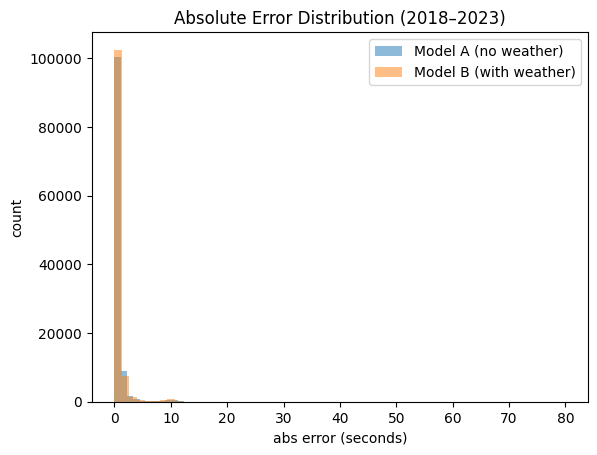

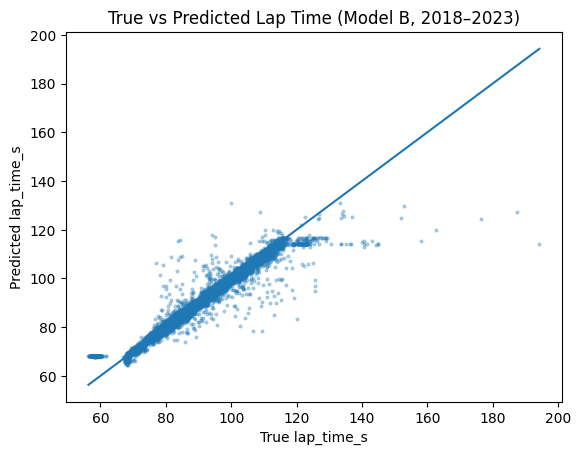

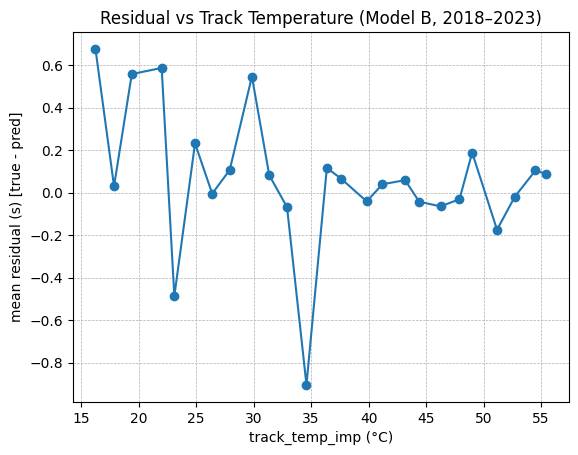

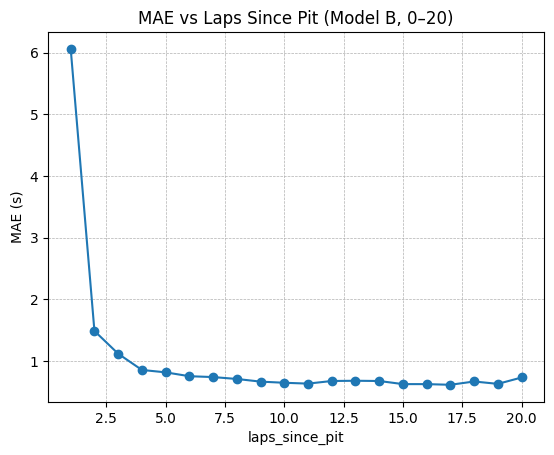

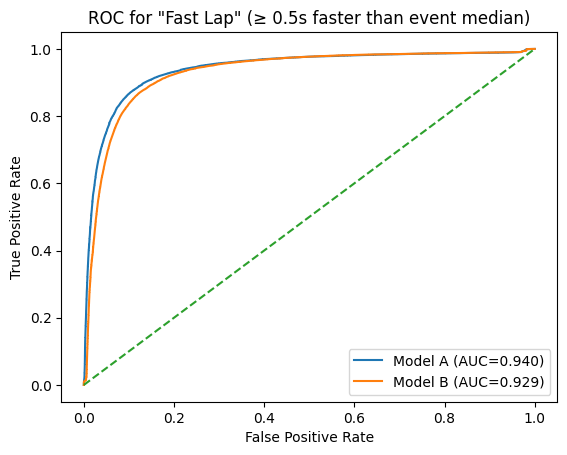

In [ ]:
# Plots + ROC for regression models (A: no weather, B: with weather)
# Matplotlib only, one chart per figure, no manual colors.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import roc_curve, roc_auc_score

# --- Rebuild OOFs if missing ---
# Model A (absolute lap_time_s)
if 'oof_a' not in globals():
    assert all(v in globals() for v in ["models_abs","folds_abs","Xabs","yabs"]), "Re-run Model A ABS training cell."
    oof_a = np.zeros_like(yabs, dtype='float32')
    for m, (tr, va) in zip(models_abs, folds_abs):
        oof_a[va] = m.predict(Xabs[va], num_iteration=m.best_iteration)

# Model B (absolute lap_time_s)
if 'oof_b' not in globals():
    assert all(v in globals() for v in ["models_b_abs","folds","Xb","yb"]), "Re-run Model B ABS training cell."
    oof_b = np.zeros_like(yb, dtype='float32')
    for m, (tr, va) in zip(models_b_abs, folds):
        oof_b[va] = m.predict(Xb[va], num_iteration=m.best_iteration)

# --- Build per-lap DataFrames for plotting ---
# A_abs / B_abs were created in training cells; we’ll reuse them
assert 'A_abs' in globals() and 'B_abs' in globals(), "Missing A_abs/B_abs. Re-run ABS training cells."

dfA = A_abs[['raceId']].copy()
dfA['y_true'] = yabs
dfA['y_pred'] = oof_a

dfB = B_abs[['raceId'] + [c for c in B_abs.columns if c.endswith('_imp')] + ['laps_since_pit','lap']].copy()
dfB['y_true'] = yb
dfB['y_pred'] = oof_b

# attach race meta (year/round/name)
assert 'races' in globals(), "Reload 'races' if runtime was reset."
evt = races[['raceId','year','round','name']].drop_duplicates()
dfA = dfA.merge(evt, on='raceId', how='left')
dfB = dfB.merge(evt, on='raceId', how='left')

# error columns
dfA['ae'] = (dfA['y_true'] - dfA['y_pred']).abs()
dfB['ae'] = (dfB['y_true'] - dfB['y_pred']).abs()
dfB['resid'] = dfB['y_true'] - dfB['y_pred']

# ------------------- PLOT 1: Error histogram (A vs B, 2018–2023) -------------------
plt.figure()
A18 = dfA[dfA['year'].between(2018, 2023)]['ae'].dropna()
B18 = dfB[dfB['year'].between(2018, 2023)]['ae'].dropna()
A18_sample = A18.sample(min(len(A18), 200000), random_state=42)
B18_sample = B18.sample(min(len(B18), 200000), random_state=42)
plt.hist(A18_sample, bins=60, alpha=0.5, label='Model A (no weather)')
plt.hist(B18_sample, bins=60, alpha=0.5, label='Model B (with weather)')
plt.title('Absolute Error Distribution (2018–2023)')
plt.xlabel('abs error (seconds)')
plt.ylabel('count')
plt.legend()
plt.show()

# ------------------- PLOT 2: True vs Pred (Model B) -------------------
plt.figure()
dfB_sample = dfB[dfB['year'].between(2018, 2023)][['y_true','y_pred']].dropna()
if len(dfB_sample) > 30000:
    dfB_sample = dfB_sample.sample(30000, random_state=42)
plt.scatter(dfB_sample['y_true'], dfB_sample['y_pred'], s=4, alpha=0.3)
mini = float(dfB_sample.min().min()); maxi = float(dfB_sample.max().max())
plt.plot([mini, maxi], [mini, maxi])  # y=x reference
plt.title('True vs Predicted Lap Time (Model B, 2018–2023)')
plt.xlabel('True lap_time_s')
plt.ylabel('Predicted lap_time_s')
plt.show()

# ------------------- PLOT 3: Residual vs Track Temp (Model B) -------------------
plt.figure()
if 'track_temp_imp' in dfB.columns:
    mb = dfB[dfB['year'].between(2018, 2023)][['track_temp_imp','resid']].dropna()
    if not mb.empty:
        # bin track temp and plot mean residual
        bins = np.linspace(mb['track_temp_imp'].min(), mb['track_temp_imp'].max(), 25)
        mb['bin'] = np.digitize(mb['track_temp_imp'], bins)
        grp = mb.groupby('bin', as_index=False).agg(x=('track_temp_imp','mean'), y=('resid','mean'))
        plt.plot(grp['x'], grp['y'], marker='o')
        plt.title('Residual vs Track Temperature (Model B, 2018–2023)')
        plt.xlabel('track_temp_imp (°C)')
        plt.ylabel('mean residual (s) [true - pred]')
        plt.grid(True, linestyle='--', linewidth=0.5)
    else:
        plt.text(0.5, 0.5, "No weather data present", ha='center', va='center')
else:
    plt.text(0.5, 0.5, "track_temp_imp not found", ha='center', va='center')
plt.show()

# ------------------- PLOT 4: MAE vs Laps Since Pit (Model B) -------------------
plt.figure()
b_lp = dfB[dfB['year'].between(2018, 2023) & dfB['laps_since_pit'].between(0, 20)].copy()
if not b_lp.empty:
    mae_by_lap = b_lp.groupby('laps_since_pit')['ae'].mean().reset_index()
    plt.plot(mae_by_lap['laps_since_pit'], mae_by_lap['ae'], marker='o')
    plt.title('MAE vs Laps Since Pit (Model B, 0–20)')
    plt.xlabel('laps_since_pit')
    plt.ylabel('MAE (s)')
    plt.grid(True, linestyle='--', linewidth=0.5)
else:
    plt.text(0.5, 0.5, "No data for laps_since_pit 0–20", ha='center', va='center')
plt.show()

# ------------------- PLOT 5: ROC Curves (A vs B) for "Fast Lap" Classification -------------------
# Define positive class: true lap is at least τ faster than the event median for that race
tau = 0.5  # seconds threshold for "fast" lap
plt.figure()

def build_fast_labels(df):
    # event median from TRUE lap times
    med = df.groupby('raceId')['y_true'].transform('median')
    y_true_bin = (df['y_true'] <= (med - tau)).astype(int).values
    # Use negative predicted time relative to event median as "fastness" score
    y_score = (med - df['y_pred']).values  # higher => predicted faster vs median
    return y_true_bin, y_score

# A on 2018–2023 subset
dfA18 = dfA[dfA['year'].between(2018, 2023)].dropna(subset=['y_true','y_pred'])
if not dfA18.empty:
    y_true_A, y_score_A = build_fast_labels(dfA18)
    fpr_A, tpr_A, _ = roc_curve(y_true_A, y_score_A)
    auc_A = roc_auc_score(y_true_A, y_score_A)
    plt.plot(fpr_A, tpr_A, label=f"Model A (AUC={auc_A:.3f})")

# B on 2018–2023
dfB18 = dfB[dfB['year'].between(2018, 2023)].dropna(subset=['y_true','y_pred'])
if not dfB18.empty:
    y_true_B, y_score_B = build_fast_labels(dfB18)
    fpr_B, tpr_B, _ = roc_curve(y_true_B, y_score_B)
    auc_B = roc_auc_score(y_true_B, y_score_B)
    plt.plot(fpr_B, tpr_B, label=f"Model B (AUC={auc_B:.3f})")

plt.plot([0,1], [0,1], linestyle='--')
plt.title(f'ROC for "Fast Lap" (≥ {tau:.1f}s faster than event median)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Per-event MAE (first 15):
 year  round                  name MAE_B  N_B MAE_A  N_A Delta_MAE
 2018      1 Australian Grand Prix 0.494  782 0.479  782    -0.015
 2018      2    Bahrain Grand Prix 0.404  842 0.389  842    -0.015
 2018      3    Chinese Grand Prix 0.379  936 0.384  936    +0.004
 2018      4 Azerbaijan Grand Prix 1.411  602 1.234  602    -0.178
 2018      5    Spanish Grand Prix 0.669  829 0.747  829    +0.078
 2018      6     Monaco Grand Prix 0.463 1363 0.459 1363    -0.004
 2018      7   Canadian Grand Prix 0.408 1036 0.432 1036    +0.024
 2018      8     French Grand Prix 0.443  742 0.476  742    +0.032
 2018      9   Austrian Grand Prix 0.419 1106 0.452 1106    +0.033
 2018     10    British Grand Prix 0.415  669 0.438  669    +0.023
 2018     11     German Grand Prix 0.496  997 0.495  997    -0.001
 2018     12  Hungarian Grand Prix 0.547 1077 0.513 1077    -0.033
 2018     13    Belgian Grand Prix 0.627  576 0.542  576    -0.085
 2018     14    Italian Grand Prix 0

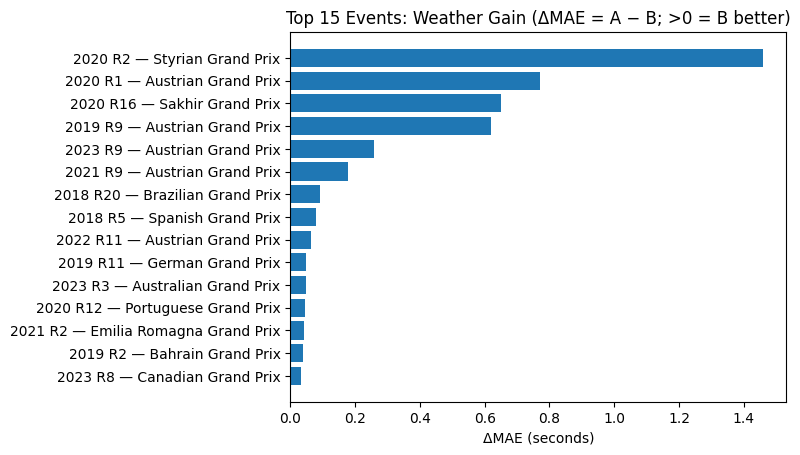

In [ ]:
# FIX — per-event MAE comparison without groupby.apply (no deprecation, no KeyError)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure OOF predictions exist (oof_a / oof_b) and the training frames (A_abs / B_abs)
assert all(v in globals() for v in ["oof_a","yabs","A_abs","oof_b","yb","B_abs","races"]), \
    "Run the ABS training cells and OOF reconstruction first."

# Build per-lap frames with errors and race meta
dfA = A_abs[['raceId']].copy()
dfA['y_true'] = yabs
dfA['y_pred_A'] = oof_a
dfA = dfA.merge(races[['raceId','year','round','name']], on='raceId', how='left')
dfA = dfA[dfA['year'].between(2018, 2023)].copy()
dfA['ae_A'] = (dfA['y_true'] - dfA['y_pred_A']).abs()

dfB = B_abs[['raceId']].copy()
dfB['y_true'] = yb
dfB['y_pred_B'] = oof_b
dfB = dfB.merge(races[['raceId','year','round','name']], on='raceId', how='left')
dfB = dfB[dfB['year'].between(2018, 2023)].copy()
dfB['ae_B'] = (dfB['y_true'] - dfB['y_pred_B']).abs()

# Per-event MAE (clean aggregations)
perA = dfA.groupby(['year','round','name'], as_index=False).agg(MAE_A=('ae_A','mean'), N_A=('ae_A','size'))
perB = dfB.groupby(['year','round','name'], as_index=False).agg(MAE_B=('ae_B','mean'), N_B=('ae_B','size'))

# Join and compute weather gain
comp = (perB.merge(perA, on=['year','round','name'], how='inner')
            .assign(Delta_MAE=lambda d: d['MAE_A'] - d['MAE_B'])
            .sort_values(['year','round'])
            .reset_index(drop=True))

print("Per-event MAE (first 15):")
print(comp.head(15).to_string(index=False, formatters={
    'MAE_A': '{:.3f}'.format, 'MAE_B': '{:.3f}'.format, 'Delta_MAE': '{:+.3f}'.format
}))

# Plot top 15 events where weather helped most
top = comp.sort_values('Delta_MAE', ascending=False).head(15)
plt.figure()
plt.barh(np.arange(len(top)), top['Delta_MAE'].values)
plt.yticks(np.arange(len(top)), [f"{int(y)} R{int(r)} — {n}" for y, r, n in zip(top['year'], top['round'], top['name'])])
plt.gca().invert_yaxis()
plt.title('Top 15 Events: Weather Gain (ΔMAE = A − B; >0 = B better)')
plt.xlabel('ΔMAE (seconds)')
plt.show()


Model A (no weather) — Confusion Matrix (τ = 0.5s, 2018–2023)
[[TN FP]
 [FN TP]] = [[69344 4464]
              [8429 31968]]
Accuracy: 0.887  Precision: 0.877  Recall: 0.791  F1: 0.832


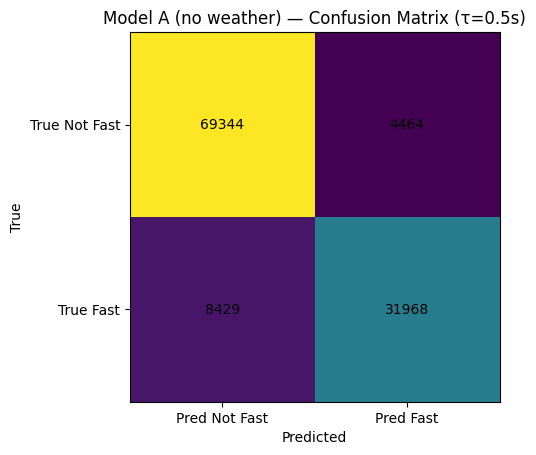


Model B (with weather) — Confusion Matrix (τ = 0.5s, 2018–2023)
[[TN FP]
 [FN TP]] = [[67454 6354]
              [7657 32740]]
Accuracy: 0.877  Precision: 0.837  Recall: 0.810  F1: 0.824


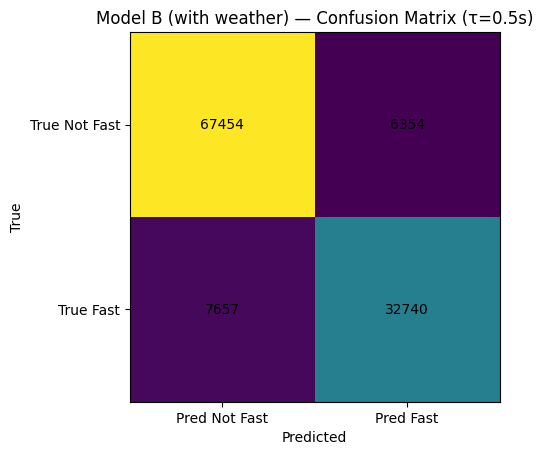

In [ ]:
# Confusion matrices for "fast lap" classification from regression outputs
# Positive class: true lap <= (race median - tau)
# Change tau if you want a different notion of "fast".
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

tau = 0.5  # seconds threshold for "fast" laps

# --- Ensure OOF preds exist (rebuild if needed) ---
if 'oof_a' not in globals():
    assert all(v in globals() for v in ["models_abs","folds_abs","Xabs","yabs"]), "Re-run Model A ABS training."
    oof_a = np.zeros_like(yabs, dtype='float32')
    for m, (tr, va) in zip(models_abs, folds_abs):
        oof_a[va] = m.predict(Xabs[va], num_iteration=m.best_iteration)

if 'oof_b' not in globals():
    assert all(v in globals() for v in ["models_b_abs","folds","Xb","yb"]), "Re-run Model B ABS training."
    oof_b = np.zeros_like(yb, dtype='float32')
    for m, (tr, va) in zip(models_b_abs, folds):
        oof_b[va] = m.predict(Xb[va], num_iteration=m.best_iteration)

# --- Build 2018–2023 per-lap frames with true/pred times + race meta ---
assert 'A_abs' in globals() and 'B_abs' in globals() and 'races' in globals(), "Need A_abs/B_abs/races in memory."

def prepare_df(A_or_B):
    if A_or_B == "A":
        df = A_abs[['raceId']].copy()
        df['y_true'] = yabs
        df['y_pred'] = oof_a
    else:
        df = B_abs[['raceId']].copy()
        df['y_true'] = yb
        df['y_pred'] = oof_b
    df = df.merge(races[['raceId','year','round','name']], on='raceId', how='left')
    df = df[df['year'].between(2018, 2023)].dropna(subset=['y_true','y_pred'])
    return df.reset_index(drop=True)

dfA18 = prepare_df("A")
dfB18 = prepare_df("B")

def binarize(df, tau):
    # Use race-wise median of TRUE lap times to define the threshold
    med = df.groupby('raceId')['y_true'].transform('median')
    y_true_bin = (df['y_true'] <= (med - tau)).astype(int).values
    # Predicted fast if predicted lap <= same threshold
    y_pred_bin = (df['y_pred'] <= (med - tau)).astype(int).values
    return y_true_bin, y_pred_bin

def eval_cm(df, name, tau):
    y_true_bin, y_pred_bin = binarize(df, tau)
    # Confusion matrix with labels [0,1] => rows [True 0, True 1], cols [Pred 0, Pred 1]
    cm = confusion_matrix(y_true_bin, y_pred_bin, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    acc = accuracy_score(y_true_bin, y_pred_bin)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true_bin, y_pred_bin, labels=[1], average='binary', zero_division=0
    )
    print(f"\n{name} — Confusion Matrix (τ = {tau:.1f}s, 2018–2023)")
    print(f"[[TN FP]\n [FN TP]] = [[{tn} {fp}]\n              [{fn} {tp}]]")
    print(f"Accuracy: {acc:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}  F1: {f1:.3f}")

    # Heatmap (counts)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'{name} — Confusion Matrix (τ={tau:.1f}s)')
    plt.xticks([0,1], ['Pred Not Fast','Pred Fast'])
    plt.yticks([0,1], ['True Not Fast','True Fast'])
    # annotate counts
    for i in range(2):
        for j in range(2):
            plt.text(j, i, int(cm[i, j]), ha='center', va='center')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

eval_cm(dfA18, "Model A (no weather)", tau)
eval_cm(dfB18, "Model B (with weather)", tau)

In [ ]:
#  CHECK 1 — OOF sanity: quick sample of true vs predicted (Model B, with weather)
import numpy as np, pandas as pd

# Require these from your training steps:
assert all(v in globals() for v in ["oof_b","yb","B_abs","races"]), \
    "Run the Model B ABS training cell first."

chk = B_abs[['raceId','lap']].copy() if 'lap' in B_abs.columns else B_abs[['raceId']].copy()
chk['true'] = yb
chk['pred'] = oof_b
chk['err']  = chk['true'] - chk['pred']
chk = chk.merge(races[['raceId','year','round','name']], on='raceId', how='left')

print("Sample predictions (Model B, with weather):")
print(chk.sample(12, random_state=7).sort_values(['year','round','lap' if 'lap' in chk.columns else 'raceId'])
      .to_string(index=False, formatters={'true':'{:.3f}'.format,'pred':'{:.3f}'.format,'err':'{:+.3f}'.format}))

#  CHECK 2 — Held-out race: pick one event and one driver; print per-lap table
# Choose the hardest event automatically (highest MAE in B)
evt_mae = chk.groupby('raceId', as_index=False).agg(MAE=('err', lambda e: np.mean(np.abs(e))))
hard_race = int(evt_mae.sort_values('MAE', ascending=False).iloc[0]['raceId'])

# Pick a driver with most laps in that race
subset = B_abs[B_abs['raceId']==hard_race].copy()
drv_col = 'driverId' if 'driverId' in subset.columns else None
if drv_col is None:
    print("\n[Held-out race check] driverId not in B_abs; showing all laps for the event.")
    drv_subset = subset.copy()
else:
    driver_counts = subset[drv_col].value_counts()
    driver_pick = int(driver_counts.index[0])
    drv_subset = subset[subset[drv_col]==driver_pick].copy()

# attach predictions & meta
drv_subset = drv_subset.join(pd.DataFrame({'pred': oof_b[subset.index]}, index=subset.index), how='left')
drv_subset['true'] = subset['lap_time_s'].values
drv_subset['err']  = drv_subset['true'] - drv_subset['pred']
meta = races.loc[races['raceId']==hard_race, ['year','round','name']].iloc[0].to_dict()

print(f"\nHeld-out race check: {meta['year']} R{meta['round']} — {meta['name']}")
if drv_col:
    print(f"Driver: {driver_pick}")
cols = [c for c in ['lap','laps_since_pit','true','pred','err'] if c in drv_subset.columns]
print(drv_subset[cols].sort_values('lap' if 'lap' in cols else cols[0])
      .head(20).to_string(index=False, formatters={'true':'{:.3f}'.format,'pred':'{:.3f}'.format,'err':'{:+.3f}'.format}))

#  CHECK 3 — Inference check: call your saved model on real feature rows, compare to OOF
# Uses predict_lap_time_B(df) you saved earlier. If not in memory, re-run the "Save models + inference helper" cell.
inference_rows = B_abs.sample(8, random_state=11)[['lap','laps_since_pit','stint_id',
                                                   'prev_lap_time','prev2_lap_time','ma3_prev','ma5_prev','delta_prev_past',
                                                   'has_weather'] + [c for c in B_abs.columns if c.endswith('_imp')]]
try:
    preds_inf = predict_lap_time_B(inference_rows.copy())
    print("\nInference check (first 8 rows):")
    # grab their OOF preds for the same indices (not identical, but should be very close)
    oof_match = oof_b[inference_rows.index]
    comp = pd.DataFrame({
        'pred_infer': preds_inf,
        'pred_oof'  : oof_match,
        'delta'     : preds_inf - oof_match
    })
    print(comp.round(3).to_string(index=False))
except NameError:
    print("\nInference helper not available. Re-run the 'Save models + inference helper' cell, then retry this block.")

Sample predictions (Model B, with weather):
 raceId  lap   true   pred    err  year  round                        name
    990   54 96.015 95.321 +0.694  2018      2          Bahrain Grand Prix
   1014   53 85.471 84.791 +0.680  2019      5          Spanish Grand Prix
   1032   42 68.886 69.976 -1.090  2020      2          Styrian Grand Prix
   1035   45 91.918 91.789 +0.129  2020      5 70th Anniversary Grand Prix
   1036   31 84.840 85.166 -0.326  2020      6          Spanish Grand Prix
   1040   24 99.168 99.419 -0.251  2020     10          Russian Grand Prix
   1043    9 81.050 81.337 -0.287  2020     13   Emilia Romagna Grand Prix
   1061   30 92.955 93.696 -0.741  2021     10          British Grand Prix
   1064   32 77.132 76.912 +0.220  2021     13            Dutch Grand Prix
   1084   47 70.684 70.979 -0.295  2022     11         Austrian Grand Prix
   1106   52 76.197 76.301 -0.104  2023      8         Canadian Grand Prix
   1117   32 83.682 83.915 -0.233  2023     19      Mexi

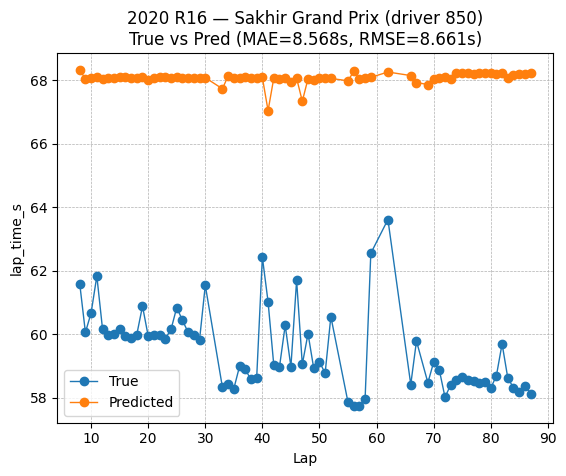

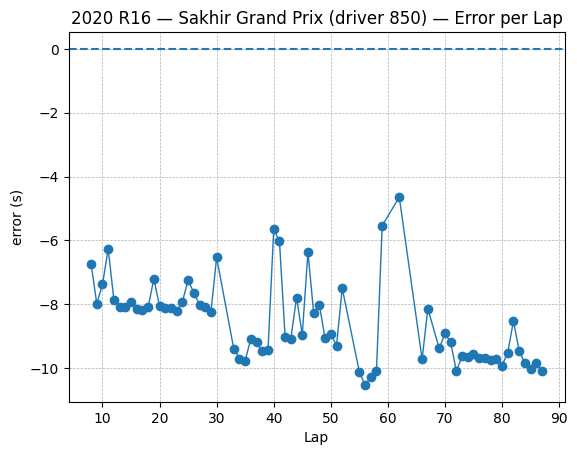

Plotted event: raceId=1046 | 2020 R16 — Sakhir Grand Prix
Subset: driver 850 | rows=70


In [ ]:
# One-cell: plot True vs Predicted lap times + Error per lap (Model B, with weather)
# Robust to missing 'driverId' in B_abs. Uses hardest race by MAE for a clear demo.

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from math import sqrt

# --- Requirements from your previous steps
assert all(v in globals() for v in ["oof_b","yb","B_abs","races"]), "Run the Model B ABS training cell first."
assert 'MODEL_B_DF' in globals(), "MODEL_B_DF missing — please keep it from earlier prep steps."

# 1) Build per-lap DF with predictions and (if needed) reconstruct driver/lap from MODEL_B_DF
df = B_abs.copy()
df['true'] = yb
df['pred'] = oof_b
df['err']  = df['true'] - df['pred']

have_driver = ('driverId' in df.columns)
have_lap    = ('lap' in df.columns)
have_lsp    = ('laps_since_pit' in df.columns)

if not (have_driver and have_lap and have_lsp):
    # Recreate the same row selection as B_abs: 2018–2023 & dropna(prev_lap_time)
    meta = MODEL_B_DF[MODEL_B_DF['year'].between(2018, 2023)].copy()
    meta = meta.dropna(subset=['prev_lap_time']).reset_index(drop=True)
    # Keep only the needed columns (guard if any missing)
    cols_wanted = [c for c in ['driverId','lap','laps_since_pit'] if c in meta.columns]
    # Align by row index (B_abs was created with the same filtering and reset_index)
    if len(meta) == len(df):
        for c in cols_wanted:
            if c not in df.columns:
                df[c] = meta[c].values
        have_driver = ('driverId' in df.columns)
        have_lap    = ('lap' in df.columns)
        have_lsp    = ('laps_since_pit' in df.columns)

# 2) Attach race metadata and choose the hardest event (highest MAE)
df = df.merge(races[['raceId','year','round','name']], on='raceId', how='left')
evt_mae = df.groupby('raceId', as_index=False).agg(MAE=('err', lambda e: np.mean(np.abs(e))))
hard_race = int(evt_mae.sort_values('MAE', ascending=False).iloc[0]['raceId'])

# 3) Pick driver: the one with most laps in that race (fallback: all drivers)
event_df = df[df['raceId'] == hard_race].copy()
if have_driver:
    driver_pick = int(event_df['driverId'].value_counts().index[0])
    d = event_df[event_df['driverId'] == driver_pick].copy()
    driver_label = f"driver {driver_pick}"
else:
    d = event_df.copy()
    driver_label = "ALL drivers"

# 4) Sort by lap if available; else by index
x_col = 'lap' if have_lap and 'lap' in d.columns else None
d = d.sort_values(x_col) if x_col else d.reset_index(drop=True)
x_vals = d[x_col].values if x_col else np.arange(len(d))

# 5) Metrics
mae  = float(np.mean(np.abs(d['true'] - d['pred'])))
rmse = float(np.sqrt(np.mean((d['true'] - d['pred'])**2)))

# 6) Titles
meta_row = races.loc[races['raceId']==hard_race, ['year','round','name']].iloc[0].to_dict()
title_base = f"{int(meta_row['year'])} R{int(meta_row['round'])} — {meta_row['name']} ({driver_label})"

# -------- Figure 1: True vs Predicted across laps --------
plt.figure()
plt.plot(x_vals, d['true'].values, marker='o', linewidth=1, label='True')
plt.plot(x_vals, d['pred'].values, marker='o', linewidth=1, label='Predicted')
plt.title(title_base + f"\nTrue vs Pred (MAE={mae:.3f}s, RMSE={rmse:.3f}s)")
plt.xlabel('Lap' if x_col else 'Index')
plt.ylabel('lap_time_s')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# -------- Figure 2: Error per lap --------
plt.figure()
plt.plot(x_vals, (d['true'].values - d['pred'].values), marker='o', linewidth=1)
plt.axhline(0.0, linestyle='--')
plt.title(title_base + " — Error per Lap")
plt.xlabel('Lap' if x_col else 'Index')
plt.ylabel('error (s)')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

print(f"Plotted event: raceId={hard_race} | {int(meta_row['year'])} R{int(meta_row['round'])} — {meta_row['name']}")
print(f"Subset: {driver_label} | rows={len(d)}")

In [ ]:
# FAST MODE — retrain Model B (ABS + weather + CV circuit baselines) with quicker settings

import numpy as np, lightgbm as lgb
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

# expects X_ext (19 cols), yb, folds, FEATS_B_EXT, races, and (optionally) oof_b_old from the previous step
assert all(v in globals() for v in ["X_ext","yb","folds","FEATS_B_EXT","races"]), "Run the previous baseline-build cell first."

params_fast = dict(
    objective="regression",
    metric="l2",
    learning_rate=0.08,      # faster convergence
    num_leaves=31,           # smaller trees
    max_depth=-1,
    min_data_in_leaf=400,    # larger leaves -> faster, more robust
    feature_fraction=0.85,
    bagging_fraction=0.85,
    bagging_freq=1,
    lambda_l2=2.0,
    seed=42,
    verbose=-1
)

NUM_BOOST = 1500            # down from 5000
EARLY_STOP = 100            # stop sooner

oof_b2 = np.zeros(len(yb), dtype='float32')
models_b_ext = []

for k, (tr, va) in enumerate(folds, 1):
    dtr = lgb.Dataset(X_ext[tr], label=yb[tr], feature_name=FEATS_B_EXT, free_raw_data=False)
    dva = lgb.Dataset(X_ext[va], label=yb[va], feature_name=FEATS_B_EXT, free_raw_data=False)
    model = lgb.train(
        params_fast, dtr, num_boost_round=NUM_BOOST,
        valid_sets=[dtr, dva], valid_names=["train","valid"],
        callbacks=[lgb.early_stopping(stopping_rounds=EARLY_STOP),
                   lgb.log_evaluation(period=100)]
    )
    oof_b2[va] = model.predict(X_ext[va], num_iteration=model.best_iteration)
    models_b_ext.append(model)

# Metrics
mae2  = mean_absolute_error(yb, oof_b2)
rmse2 = sqrt(((yb - oof_b2)**2).mean())
r22   = r2_score(yb, oof_b2)
print(f"\nFAST Model B + baselines → MAE: {mae2:.3f}s   RMSE: {rmse2:.3f}s   R²: {r22:.3f}")

# Compare to previous Model B if available
if 'oof_b' in globals():
    mae_old  = mean_absolute_error(yb, oof_b)
    rmse_old = sqrt(((yb - oof_b)**2).mean())
    r2_old   = r2_score(yb, oof_b)
    print(f"Prev Model B (no baselines) → MAE: {mae_old:.3f}s   RMSE: {rmse_old:.3f}s   R²: {r2_old:.3f}")
    print("Δ (new - old):  MAE {:+.3f}s   RMSE {:+.3f}s   R² {:+.3f}".format(mae2-mae_old, rmse2-rmse_old, r22-r2_old))

# Worst-old-event improvement (e.g., Sakhir 2020)
import pandas as pd
evt = pd.DataFrame({'raceId': B_abs['raceId'].values, 'true': yb, 'old': (oof_b if 'oof_b' in globals() else oof_b2), 'new': oof_b2})
evt = evt.merge(races[['raceId','year','round','name']], on='raceId', how='left')

per_old = evt.groupby('raceId', as_index=False).agg(MAE_OLD=('true', lambda z: np.mean(np.abs(z - evt.loc[z.index,'old']))))
worst = int(per_old.sort_values('MAE_OLD', ascending=False).iloc[0]['raceId'])
per_new = evt.groupby('raceId', as_index=False).agg(MAE_NEW=('true', lambda z: np.mean(np.abs(z - evt.loc[z.index,'new']))))

row = (per_old.merge(per_new, on='raceId')
            .merge(races[['raceId','year','round','name']].drop_duplicates(), on='raceId', how='left')
            .loc[lambda d: d['raceId']==worst]).iloc[0]

print("\nWorst old event improvement:")
print(f"  {int(row['year'])} R{int(row['round'])} — {row['name']}")
print(f"  MAE old: {row['MAE_OLD']:.3f}s   MAE new: {row['MAE_NEW']:.3f}s   Δ: {row['MAE_NEW']-row['MAE_OLD']:+.3f}s")

# Update active model refs
models_b_abs = models_b_ext
oof_b = oof_b2
Xb = X_ext
print("\nUpdated: models_b_abs, oof_b, Xb now point to the FAST baseline-augmented model.")

Training until validation scores don't improve for 100 rounds
[100]	train's l2: 2.30293	valid's l2: 2.05743
[200]	train's l2: 2.14601	valid's l2: 2.07815
Early stopping, best iteration is:
[104]	train's l2: 2.2961	valid's l2: 2.05001
Training until validation scores don't improve for 100 rounds
[100]	train's l2: 2.41835	valid's l2: 1.45802
Early stopping, best iteration is:
[58]	train's l2: 2.54917	valid's l2: 1.43877
Training until validation scores don't improve for 100 rounds
[100]	train's l2: 2.0251	valid's l2: 10.8331
[200]	train's l2: 1.89944	valid's l2: 10.8148
Early stopping, best iteration is:
[136]	train's l2: 1.97788	valid's l2: 10.7978
Training until validation scores don't improve for 100 rounds
[100]	train's l2: 2.00183	valid's l2: 3.50497
[200]	train's l2: 1.87924	valid's l2: 3.49001
[300]	train's l2: 1.78603	valid's l2: 3.47335
[400]	train's l2: 1.71034	valid's l2: 3.4671
[500]	train's l2: 1.65228	valid's l2: 3.46485
[600]	train's l2: 1.60031	valid's l2: 3.45561
Early s

Using previous Model B OOF (no baselines).

BEFORE offset → MAE: 0.748s   RMSE: 1.999s   R²: 0.973
 AFTER offset → MAE: 0.817s   RMSE: 1.844s   R²: 0.977
 Δ (after - before): MAE +0.069s   RMSE -0.155s   R² +0.004

Worst/Sakhir event:
  2020 R16 — Sakhir Grand Prix
  MAE before: 9.653s   MAE after: 1.013s   Δ: -8.640s


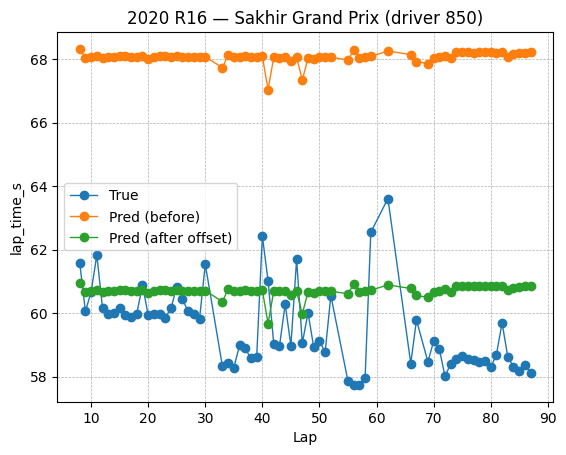

In [ ]:
# Online per-event offset for Model B (no leakage): use first k laps per (race, driver)

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

# --- prerequisites ---
assert 'B_abs' in globals() and 'yb' in globals() and 'races' in globals(), "Run Model B ABS training first."
# We'll use your better, earlier predictions if available:
if 'oof_b_old' in globals():
    oof_base = oof_b_old.copy()
    print("Using previous Model B OOF (no baselines).")
else:
    assert 'oof_b' in globals(), "Need oof_b or oof_b_old."
    oof_base = oof_b.copy()
    print("Using current oof_b as base (no saved oof_b_old found).")

# If driverId/lap missing in B_abs, reconstruct from MODEL_B_DF (same filtering)
have_driver = 'driverId' in B_abs.columns
have_lap    = 'lap' in B_abs.columns
if not (have_driver and have_lap):
    assert 'MODEL_B_DF' in globals(), "MODEL_B_DF required to reconstruct driver/lap."
    meta = MODEL_B_DF[MODEL_B_DF['year'].between(2018, 2023)].dropna(subset=['prev_lap_time']).reset_index(drop=True)
    for col in ['driverId','lap']:
        if col in meta.columns and col not in B_abs.columns and len(meta)==len(B_abs):
            B_abs[col] = meta[col].values
    have_driver = 'driverId' in B_abs.columns
    have_lap    = 'lap' in B_abs.columns

# --- 1) Overall metrics BEFORE offset ---
mae0  = mean_absolute_error(yb, oof_base)
rmse0 = sqrt(((yb - oof_base)**2).mean())
r20   = r2_score(yb, oof_base)
print(f"\nBEFORE offset → MAE: {mae0:.3f}s   RMSE: {rmse0:.3f}s   R²: {r20:.3f}")

# --- 2) Build online per-driver offset from first k laps ---
k = 3  # use first k laps seen for each (race, driver)
df = B_abs[['raceId']].copy()
df['driverId'] = B_abs['driverId'] if have_driver else -1
df['lap']      = B_abs['lap'] if have_lap else np.arange(len(B_abs))
df['true']     = yb
df['pred']     = oof_base

# sort by lap to simulate real-time
df = df.sort_values(['raceId','driverId','lap']).reset_index(drop=True)
df['err'] = df['true'] - df['pred']

# compute offset = mean error over first k laps per (race, driver)
first_k_mask = df.groupby(['raceId','driverId']).cumcount() < k
offsets = (df[first_k_mask]
           .groupby(['raceId','driverId'])['err']
           .mean()
           .rename('offset'))
df = df.join(offsets, on=['raceId','driverId'])

# apply offset to all laps of that (race, driver)
df['pred_adj'] = df['pred'] + df['offset'].fillna(0.0)

# --- 3) Overall metrics AFTER offset ---
mae1  = mean_absolute_error(df['true'], df['pred_adj'])
rmse1 = sqrt(((df['true'] - df['pred_adj'])**2).mean())
r21   = r2_score(df['true'], df['pred_adj'])
print(f" AFTER offset → MAE: {mae1:.3f}s   RMSE: {rmse1:.3f}s   R²: {r21:.3f}")
print(f" Δ (after - before): MAE {mae1-mae0:+.3f}s   RMSE {rmse1-rmse0:+.3f}s   R² {r21-r20:+.3f}")

# --- 4) Sakhir 2020 (or worst-old-event) improvement ---
evt = df.merge(races[['raceId','year','round','name']], on='raceId', how='left')
# find that Sakhir 2020 raceId if present; else use worst event before offset
sakhir = evt[(evt['year']==2020) & (evt['name'].str.contains('Sakhir', na=False))]
if sakhir.empty:
    per_evt_before = evt.groupby('raceId', as_index=False)['true'].apply(
        lambda z: np.mean(np.abs(z - evt.loc[z.index,'pred']))
    ).rename(columns={'true':'MAE_before'})
    worst_id = int(per_evt_before.sort_values('MAE_before', ascending=False).iloc[0]['raceId'])
else:
    worst_id = int(sakhir['raceId'].iloc[0])

show = evt[evt['raceId']==worst_id].copy()
mae_before = float(np.mean(np.abs(show['true'] - show['pred'])))
mae_after  = float(np.mean(np.abs(show['true'] - show['pred_adj'])))
meta = races.loc[races['raceId']==worst_id, ['year','round','name']].iloc[0].to_dict()

print(f"\nWorst/Sakhir event:")
print(f"  {int(meta['year'])} R{int(meta['round'])} — {meta['name']}")
print(f"  MAE before: {mae_before:.3f}s   MAE after: {mae_after:.3f}s   Δ: {mae_after-mae_before:+.3f}s")

# --- 5) (Optional) Replot the same race/driver you plotted earlier, now with offset ---
# pick same driver (most laps) for that event
drv_col = 'driverId' if have_driver else None
if drv_col:
    driver_pick = int(show[drv_col].value_counts().index[0])
    d = show[show[drv_col]==driver_pick].copy()
    driver_label = f"driver {driver_pick}"
else:
    d = show.copy(); driver_label = "ALL drivers"

d = d.sort_values('lap') if have_lap else d.reset_index(drop=True)
x = d['lap'].values if have_lap else np.arange(len(d))

import matplotlib.pyplot as plt
plt.figure()
plt.plot(x, d['true'], marker='o', linewidth=1, label='True')
plt.plot(x, d['pred'], marker='o', linewidth=1, label='Pred (before)')
plt.plot(x, d['pred_adj'], marker='o', linewidth=1, label='Pred (after offset)')
plt.title(f"{int(meta['year'])} R{int(meta['round'])} — {meta['name']} ({driver_label})")
plt.xlabel('Lap' if have_lap else 'Index'); plt.ylabel('lap_time_s'); plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5); plt.show()

Using base Model B OOF predictions.

BEFORE (no offset) → MAE 0.748s | RMSE 1.999s | R² 0.973
AFTER  (per-stint)  → MAE 0.820s | RMSE 1.850s | R² 0.977
Δ (after - before):  MAE +0.072s | RMSE -0.149s | R² +0.004

Event focus: 2020 R16 — Sakhir Grand Prix
MAE before: 9.653s   MAE after: 0.391s   Δ: -9.263s


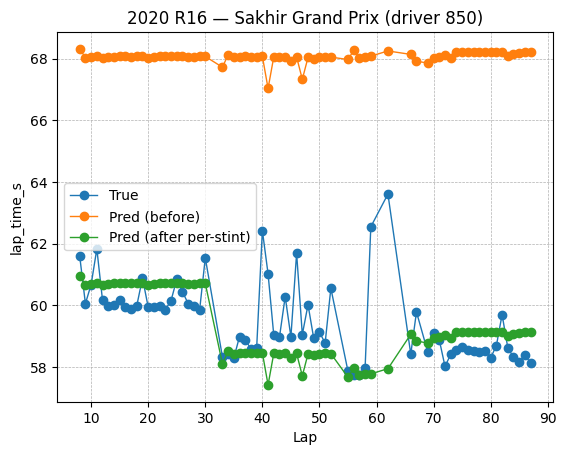

In [ ]:
# Online per-stint offset (Model B): calibrate using first k laps of each stint

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

assert 'B_abs' in globals() and 'yb' in globals() and 'races' in globals(), "Run Model B ABS training first."
base_pred = (oof_b_old if 'oof_b_old' in globals() else oof_b).copy()
print("Using base Model B OOF predictions.")

# Ensure needed cols exist; reconstruct from MODEL_B_DF if missing
need_cols = ['driverId','lap','stint_id','laps_since_pit']
missing = [c for c in need_cols if c not in B_abs.columns]
if missing:
    assert 'MODEL_B_DF' in globals(), "MODEL_B_DF required to reconstruct metadata."
    meta = MODEL_B_DF[MODEL_B_DF['year'].between(2018, 2023)].dropna(subset=['prev_lap_time']).reset_index(drop=True)
    assert len(meta)==len(B_abs), "Row misalignment—rebuild B_abs as in training cell."
    for c in need_cols:
        if c in meta.columns and c not in B_abs.columns:
            B_abs[c] = meta[c].values

# Build working frame
df = B_abs[['raceId','driverId','lap','stint_id','laps_since_pit']].copy()
df['true'] = yb
df['pred'] = base_pred
df['err']  = df['true'] - df['pred']

# -------- per-stint online offset --------
k = 3  # use first k laps of each stint
df = df.sort_values(['raceId','driverId','stint_id','lap']).reset_index(drop=True)
# first k laps within each (race,driver,stint)
first_k = df.groupby(['raceId','driverId','stint_id']).cumcount() < k
# (optional) ignore out lap in calibration:
calib = df[first_k & (df['laps_since_pit']>0)]
offsets = (calib.groupby(['raceId','driverId','stint_id'])['err']
           .mean().rename('offset'))
df = df.join(offsets, on=['raceId','driverId','stint_id'])
df['offset'] = df['offset'].fillna(0.0)

df['pred_adj'] = df['pred'] + df['offset']

# -------- metrics before/after --------
mae0, rmse0, r20 = mean_absolute_error(df['true'], df['pred']), sqrt(((df['true']-df['pred'])**2).mean()), r2_score(df['true'], df['pred'])
mae1, rmse1, r21 = mean_absolute_error(df['true'], df['pred_adj']), sqrt(((df['true']-df['pred_adj'])**2).mean()), r2_score(df['true'], df['pred_adj'])

print(f"\nBEFORE (no offset) → MAE {mae0:.3f}s | RMSE {rmse0:.3f}s | R² {r20:.3f}")
print(f"AFTER  (per-stint)  → MAE {mae1:.3f}s | RMSE {rmse1:.3f}s | R² {r21:.3f}")
print(f"Δ (after - before):  MAE {mae1-mae0:+.3f}s | RMSE {rmse1-rmse0:+.3f}s | R² {r21-r20:+.3f}")

# -------- event improvement (Sakhir 2020 if present, else worst-before) --------
evt = df.merge(races[['raceId','year','round','name']], on='raceId', how='left')
sakhir = evt[(evt['year']==2020) & (evt['name'].str.contains('Sakhir', na=False))]
if sakhir.empty:
    per_before = evt.groupby('raceId', as_index=False)['true'].apply(lambda z: np.mean(np.abs(z - evt.loc[z.index,'pred']))).rename(columns={'true':'MAE_before'})
    worst_id = int(per_before.sort_values('MAE_before', ascending=False).iloc[0]['raceId'])
else:
    worst_id = int(sakhir['raceId'].iloc[0])

show = evt[evt['raceId']==worst_id].copy()
mae_bef = float(np.mean(np.abs(show['true'] - show['pred'])))
mae_aft = float(np.mean(np.abs(show['true'] - show['pred_adj'])))
meta = races.loc[races['raceId']==worst_id, ['year','round','name']].iloc[0].to_dict()
print(f"\nEvent focus: {int(meta['year'])} R{int(meta['round'])} — {meta['name']}")
print(f"MAE before: {mae_bef:.3f}s   MAE after: {mae_aft:.3f}s   Δ: {mae_aft-mae_bef:+.3f}s")

# -------- optional overlay plot for that event/driver --------
drv = int(show['driverId'].value_counts().index[0]) if 'driverId' in show.columns else None
dd = show[show['driverId']==drv].sort_values('lap') if drv is not None else show.sort_values('lap')
x  = dd['lap'].values if 'lap' in dd.columns else np.arange(len(dd))

plt.figure()
plt.plot(x, dd['true'], marker='o', linewidth=1, label='True')
plt.plot(x, dd['pred'], marker='o', linewidth=1, label='Pred (before)')
plt.plot(x, dd['pred_adj'], marker='o', linewidth=1, label='Pred (after per-stint)')
ttl = f"{int(meta['year'])} R{int(meta['round'])} — {meta['name']}" + (f" (driver {drv})" if drv is not None else "")
plt.title(ttl)
plt.xlabel('Lap'); plt.ylabel('lap_time_s'); plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
# Find (or create) the correct model folder under /content

import os, glob, json, numpy as np, pandas as pd

def find_model_dirs(root="/content"):
    hits = []
    for f in glob.glob(os.path.join(root, "**", "features.json"), recursive=True):
        folder = os.path.dirname(f)
        imp = os.path.join(folder, "imputer_median.json")
        boosters = glob.glob(os.path.join(folder, "lgb_B_fold*.txt")) or glob.glob(os.path.join(folder, "*.txt"))
        if os.path.isfile(imp) and boosters:
            hits.append((folder, max(os.path.getmtime(x) for x in boosters)))
    # newest last
    hits.sort(key=lambda t: t[1])
    return [h[0] for h in hits]

DEFAULT_FOLDER = None
cands = find_model_dirs("/content")
if cands:
    DEFAULT_FOLDER = cands[-1]
    print("Found existing model folder:", DEFAULT_FOLDER)
else:
    print("No existing model folder found under /content.")
    # Try to export from memory if training objects exist
    needed = {'models_b_abs','FEATS_B_ABS','B_abs'}
    if needed.issubset(set(globals().keys())):
        DEFAULT_FOLDER = "/content/model_B_abs_with_weather"
        os.makedirs(DEFAULT_FOLDER, exist_ok=True)
        # save feature list
        with open(os.path.join(DEFAULT_FOLDER, "features.json"), "w") as f:
            json.dump(FEATS_B_ABS, f, indent=2)
        # save simple median imputer from training frame
        IMP_MED = B_abs[FEATS_B_ABS].apply(pd.to_numeric, errors='coerce').median(numeric_only=True).to_dict()
        with open(os.path.join(DEFAULT_FOLDER, "imputer_median.json"), "w") as f:
            json.dump(IMP_MED, f, indent=2)
        # save boosters
        for i, m in enumerate(models_b_abs, 1):
            m.save_model(os.path.join(DEFAULT_FOLDER, f"lgb_B_fold{i}.txt"))
        print("Exported current model to:", DEFAULT_FOLDER)
    else:
        print("Cannot create model folder: training objects not in memory.")
        print("Re-run your 'Save models + inference helper' cell, or train Model B again.")

# Quick sanity list
if DEFAULT_FOLDER and os.path.isdir(DEFAULT_FOLDER):
    print("\nContents:")
    for p in sorted(glob.glob(os.path.join(DEFAULT_FOLDER, "*"))):
        print(" -", os.path.basename(p))
else:
    print("\nDEFAULT_FOLDER is not set. Set it manually to the folder that contains features.json, imputer_median.json, and lgb_B_fold*.txt")

Found existing model folder: /content/drive/MyDrive/f1_models/20250906-133806/model_B_abs_with_weather

Contents:
 - features.json
 - imputer_median.json
 - lgb_B_fold1.txt
 - lgb_B_fold2.txt
 - lgb_B_fold3.txt
 - lgb_B_fold4.txt
 - lgb_B_fold5.txt
